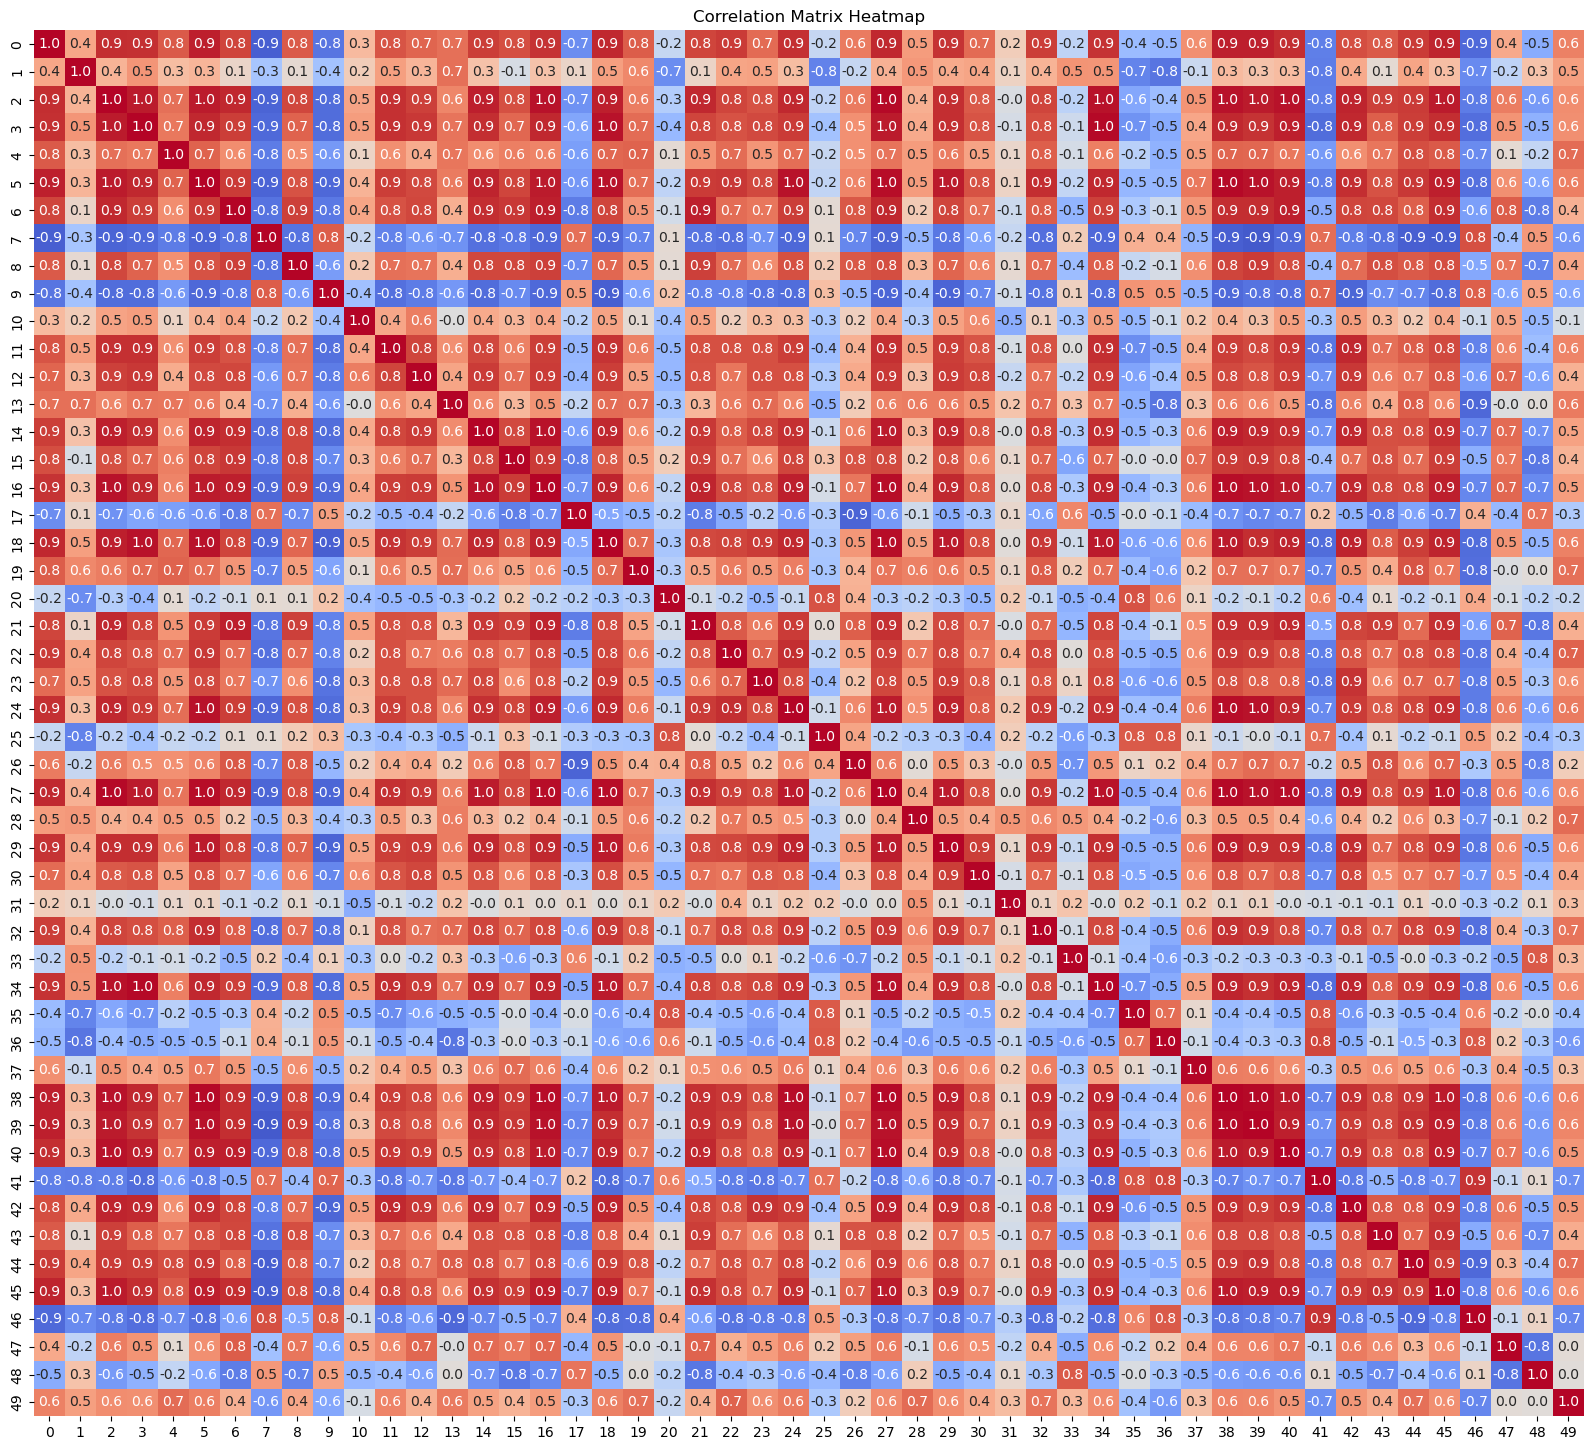

<Axes: title={'center': 'Correlation Matrix Heatmap'}>

In [9]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint, adfuller
import statsmodels.api as sm

def get_prices() -> pd.DataFrame:
    return pd.read_csv('prices.txt', delim_whitespace="True", header=None)

def plot_corr_heatmap(corr_matrix):
    plt.figure(figsize=(20, 18))
    corr_heatmap = sb.heatmap(corr_matrix, vmin=-1, vmax=1, cmap="coolwarm", annot=True, cbar=False, fmt=".1f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()
    return corr_heatmap


def plot_cov_heatmap(cov_matrix):
    plt.figure(figsize=(20, 18))
    cov_heatmap = sb.heatmap(
        cov_matrix, vmin=-1, vmax=1, cmap="coolwarm", annot=True, cbar=False, fmt=".1f")
    plt.title("Covariance Matrix Heatmap")
    plt.show()
    return cov_heatmap

prices = get_prices()
trainingsplit = 750
training_data = prices.loc[:trainingsplit]
test_data = prices.loc[trainingsplit:]


corr_matrix = round(prices.corr(), 2)
cov_matrix = round(prices.cov(), 2)

plot_corr_heatmap(corr_matrix)

In [20]:
filteredDf = np.tril(corr_matrix[
    ((corr_matrix >= 0.2) | (corr_matrix <= -0.2)) & (corr_matrix != 1.000)
], k=-1)

def high_corr_list(corr_matrix: pd.DataFrame):
    correlated_stocks = []

    for i in range(len(corr_matrix)):
        correlated_stocks.append([])
        for j in range(len(corr_matrix)):
            if corr_matrix[i, j] != 0 and not np.isnan(corr_matrix[i, j]):
                correlated_stocks[i].append(j)

    return correlated_stocks


corrolated_stocks = high_corr_list(filteredDf)


def plot_correlated_stocks(stock_i, daily_prices, correlated_stocks):
    correlated_indices = correlated_stocks[stock_i]
    correlated_indices.append(stock_i)  # Include the given stock itself

    plt.figure(figsize=(14, 8))
    for idx in correlated_indices:
        plt.plot(daily_prices.index, daily_prices.iloc[:, idx], label=f"Stock{idx}")

    plt.title(f"Stock{stock_i} and its Highly Correlated Stocks")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

TypeError: plot_correlated_stocks() missing 2 required positional arguments: 'daily_prices' and 'correlated_stocks'

In [15]:
def plot_residuals(pair, residuals):
    stock_i, stock_j = pair
    plt.figure(figsize=(10, 6))

    # Plot the residuals
    plt.plot(residuals, label=f"Residuals of {stock_i} and {stock_j}")

    # Add a horizontal line at y=0
    plt.axhline(y=0, color="r", linestyle="--", label="Mean")

    # Calculate z-scores of +1.2 and -1.2
    z_score = 1.1
    std_dev = np.std(residuals)
    upper_bound = z_score * std_dev
    lower_bound = -z_score * std_dev

    # Add horizontal lines at z-scores of +1.2 and -1.2
    plt.axhline(y=upper_bound, color="g", linestyle=":", label="Z-score = +1.2")
    plt.axhline(y=lower_bound, color="g", linestyle=":", label="Z-score = -1.2")

    plt.title(f"Residuals of OLS Regression between {stock_i} and {stock_j}")
    plt.xlabel("Time")
    plt.ylabel("Residuals")
    plt.legend()
    plt.show()


# Plot residuals for each cointegrated pair

def plotresids():
    for pair in pairs:
        i, j = pruned_log_prices.columns.get_loc(
            pair[0]
        ), pruned_log_prices.columns.get_loc(pair[1])
        residuals = residual_matrix[i, j]
        plot_residuals(pair, residuals)

def plotpairs(unique_pairs):
    for pair in unique_pairs:
        S1 = prices[pair[0]]
        S2 = prices[pair[1]]
        ratios = S1 / S2
        plt.figure(figsize=(10, 6))
        plt.plot(ratios)
        plt.axhline(ratios.mean(), color="red", linestyle="--")
        plt.title(f"Price Ratio between {pair[0]} and {pair[1]}")
        plt.xlabel("Date")
        plt.ylabel("Price Ratio")
        plt.legend(["Price Ratio"])
        plt.show()



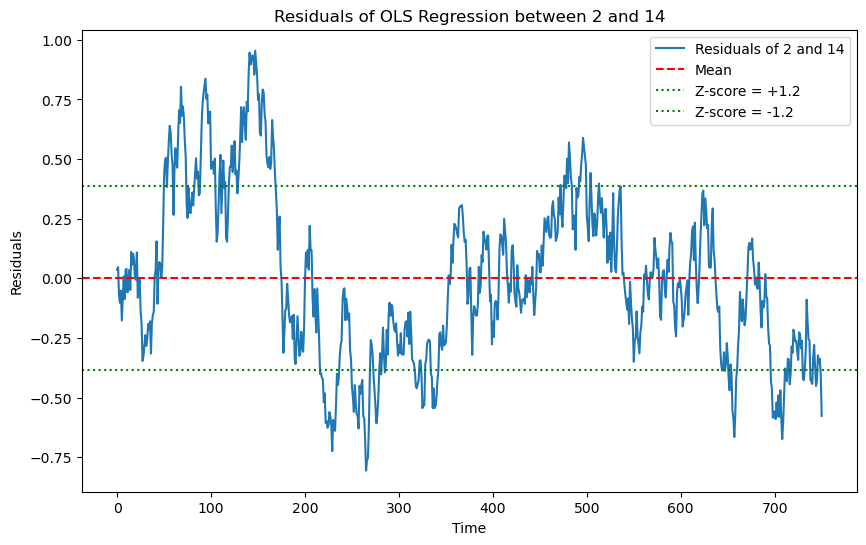

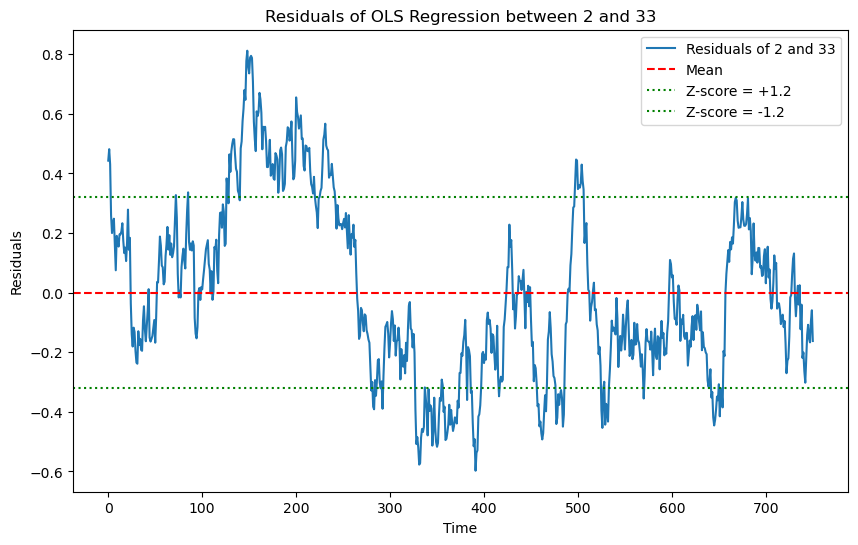

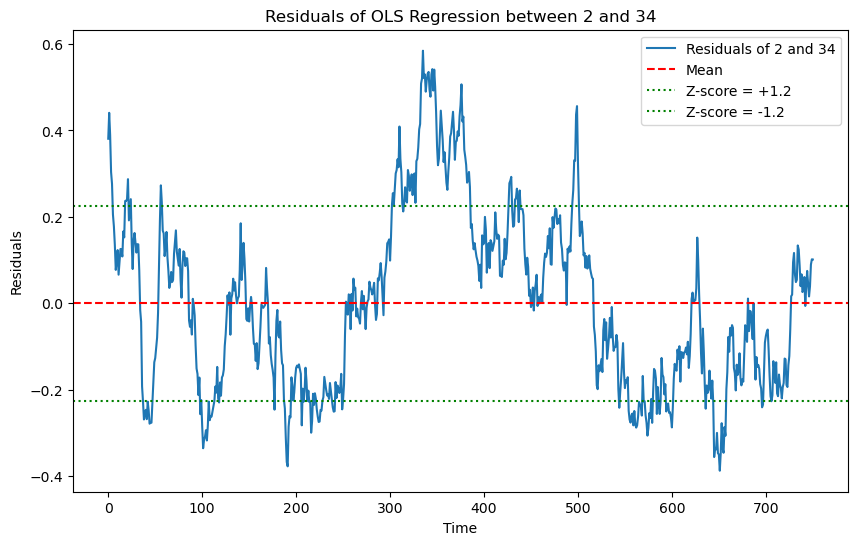

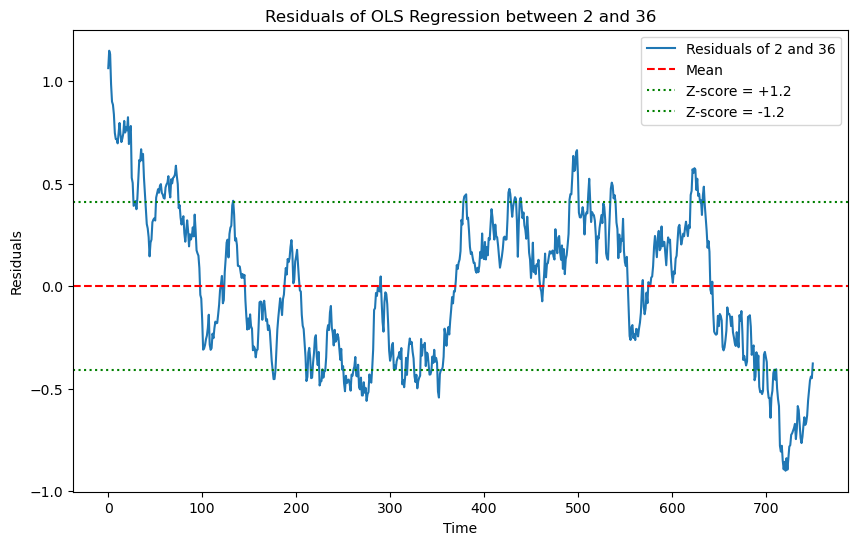

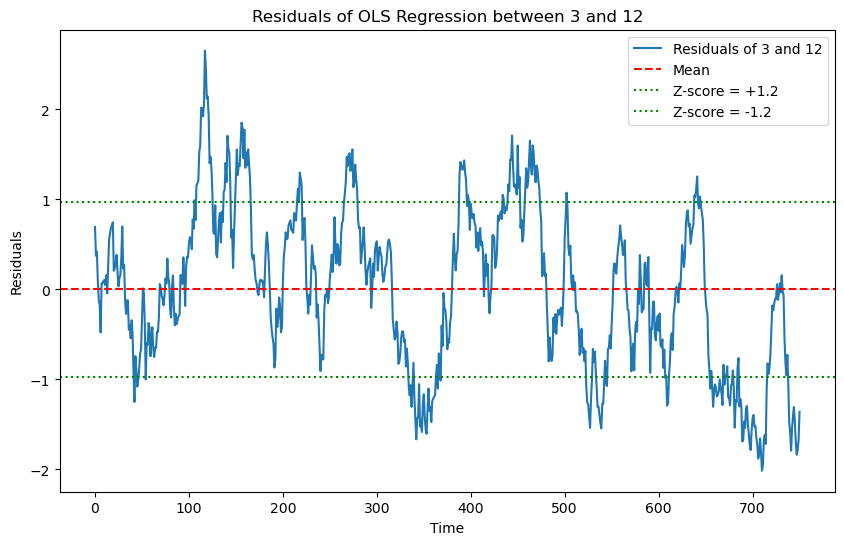

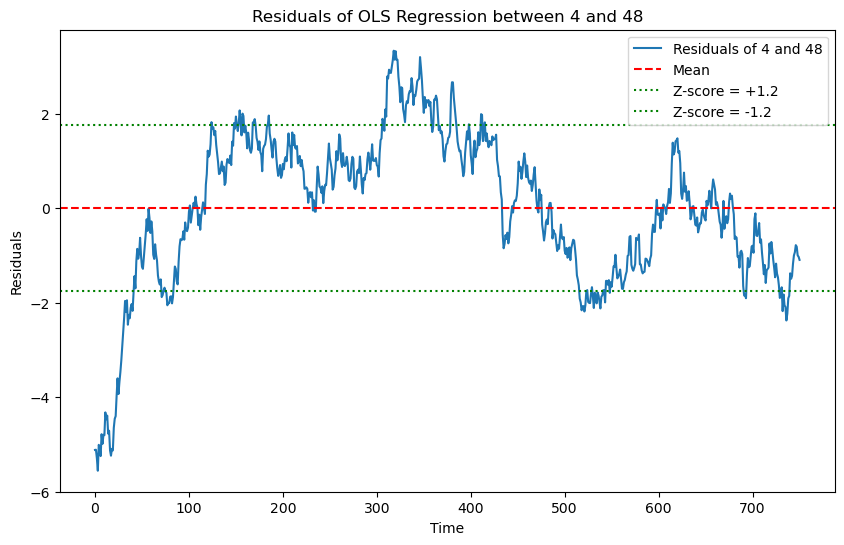

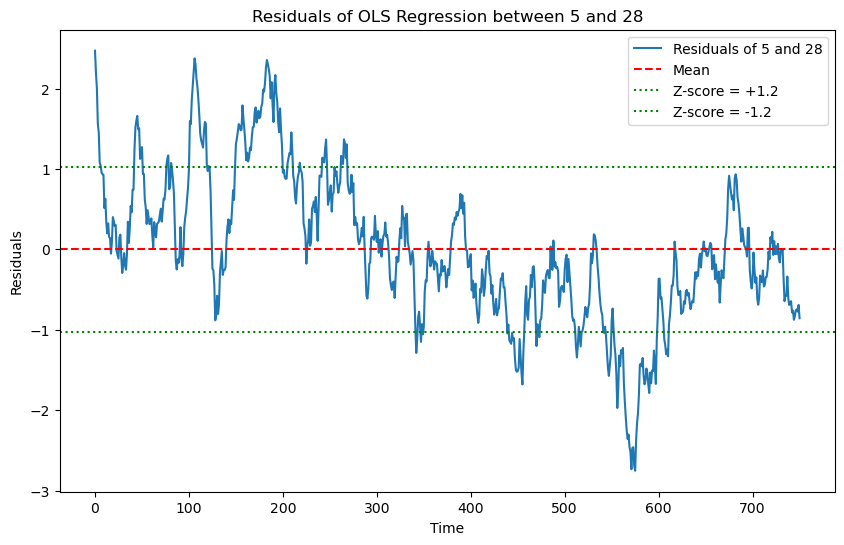

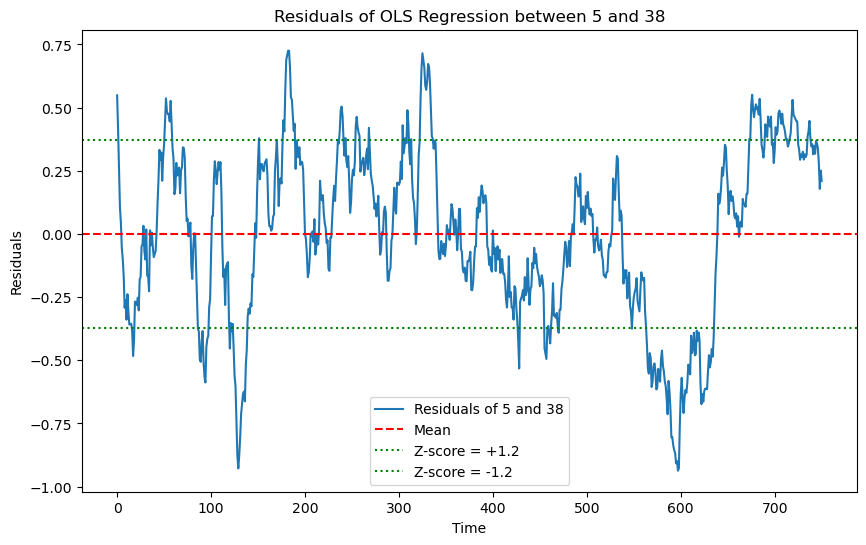

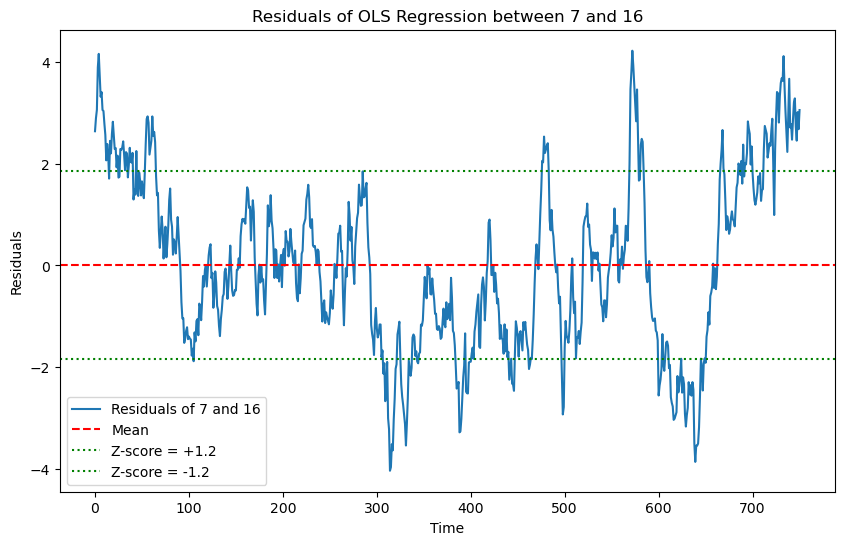

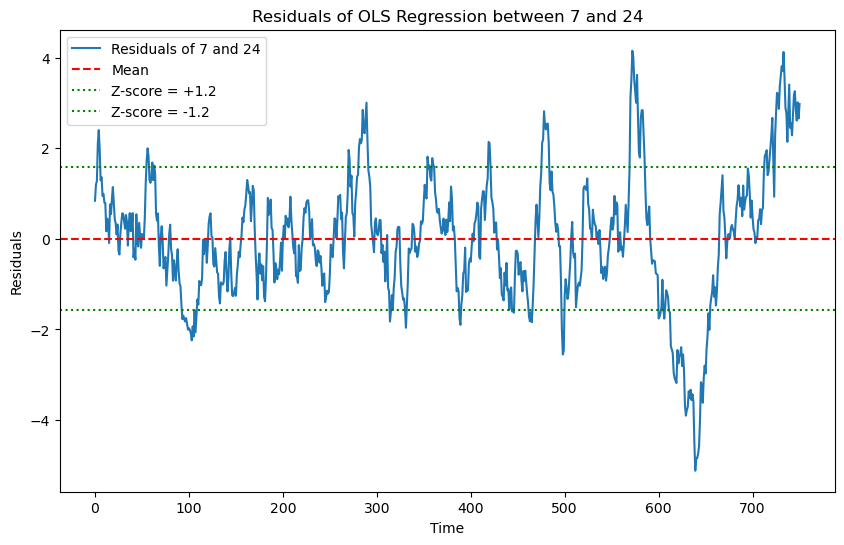

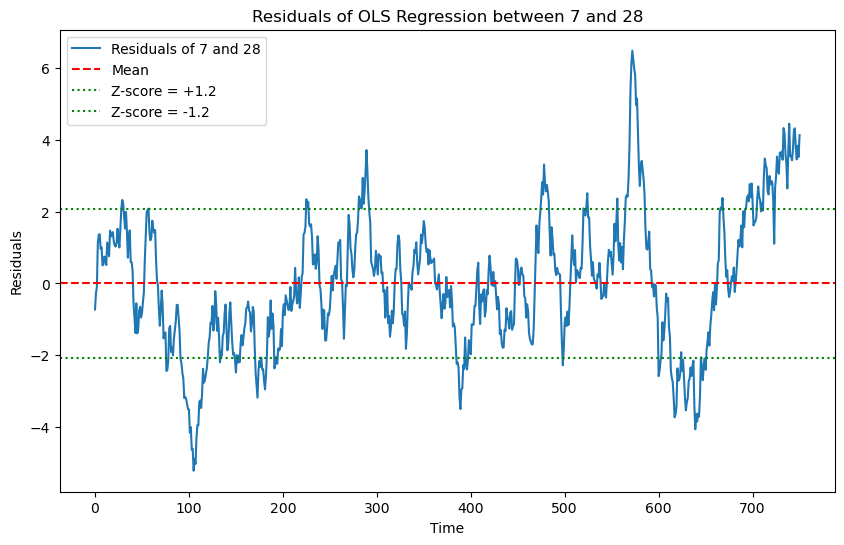

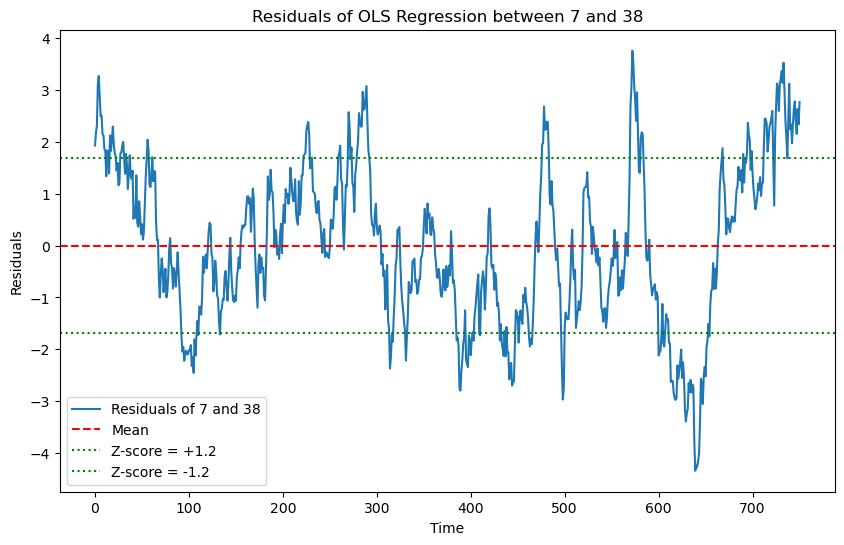

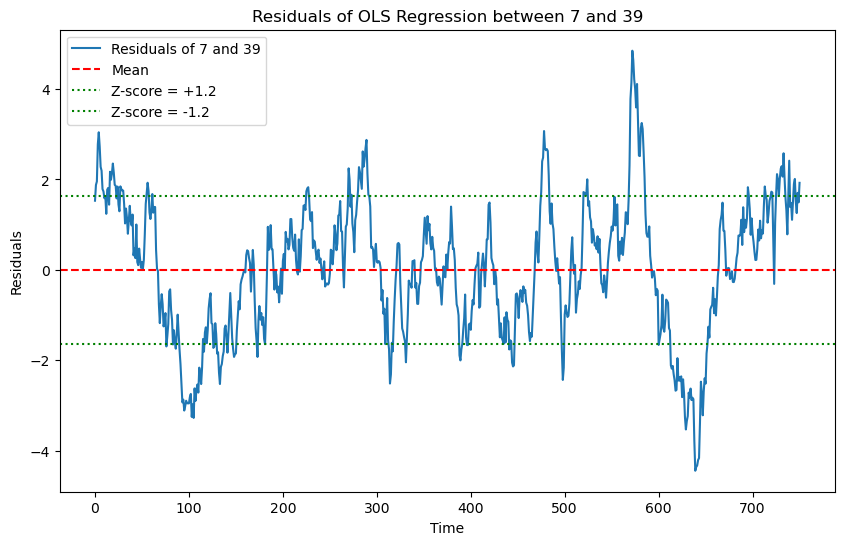

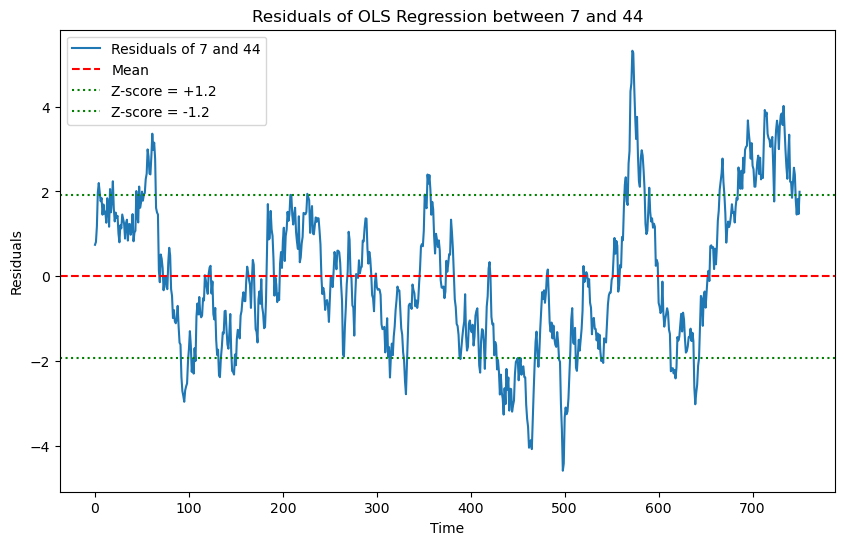

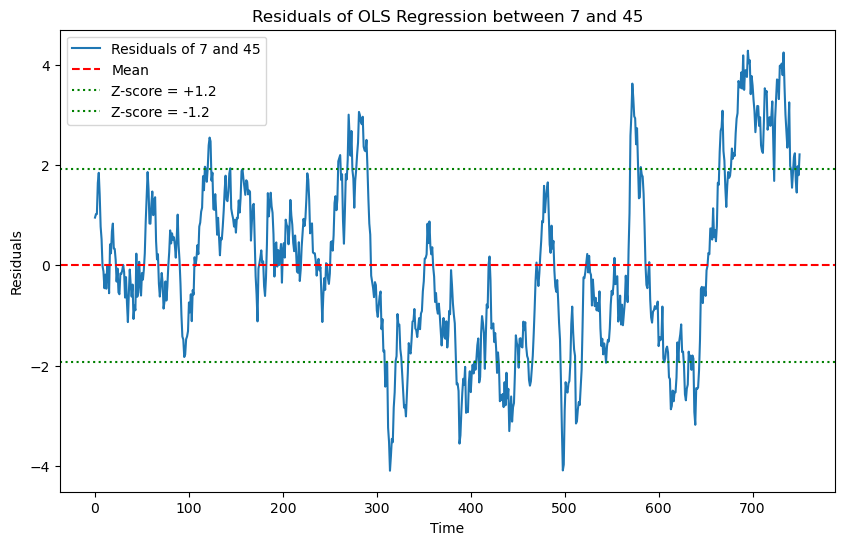

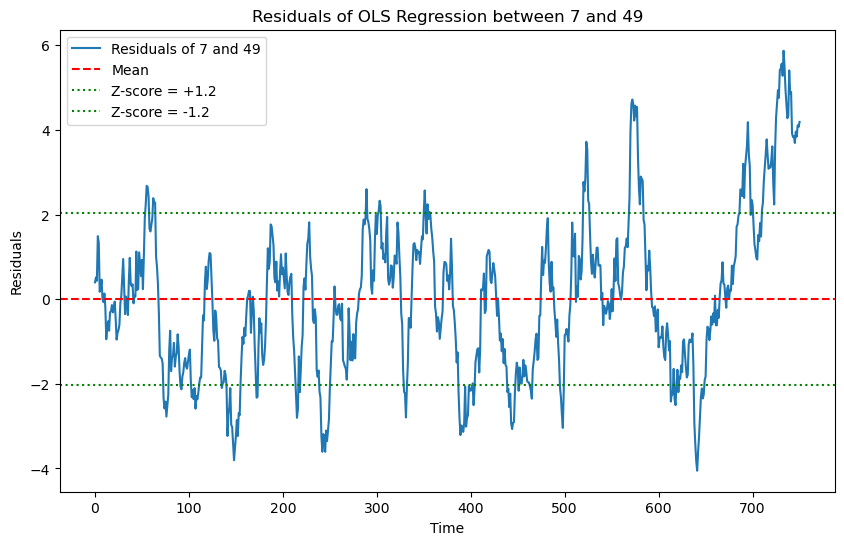

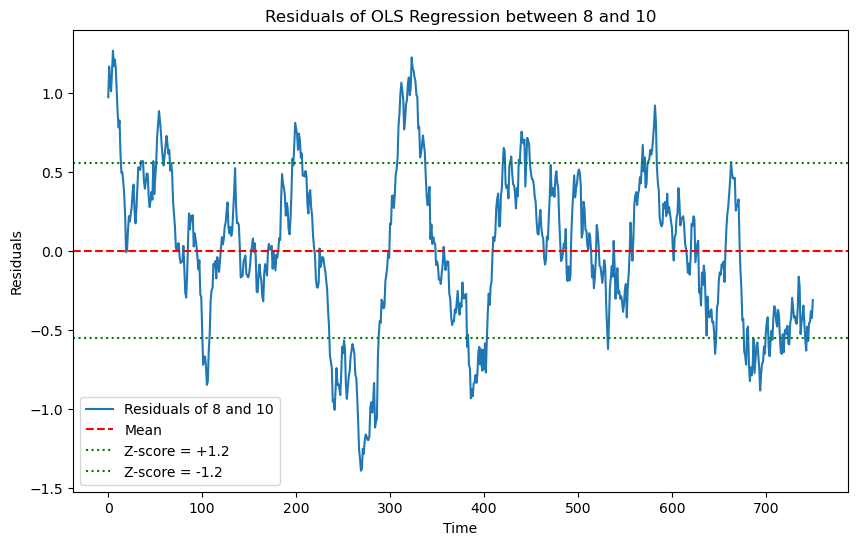

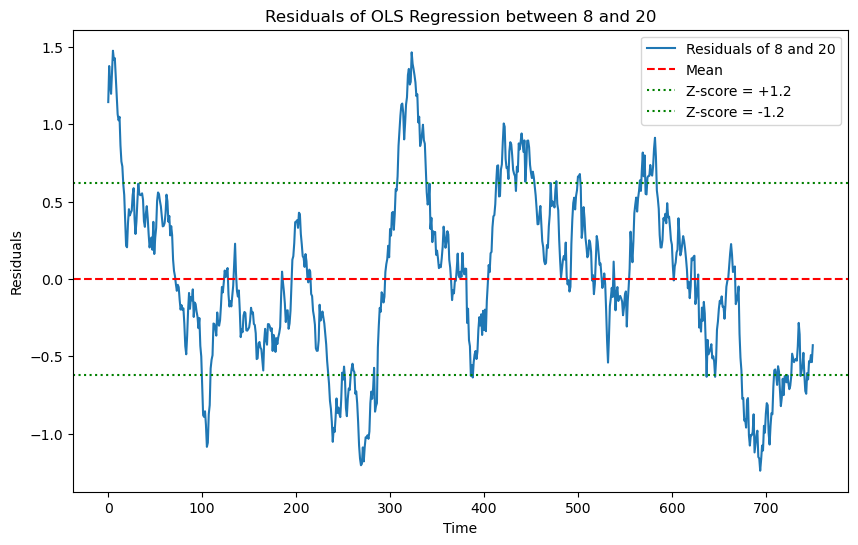

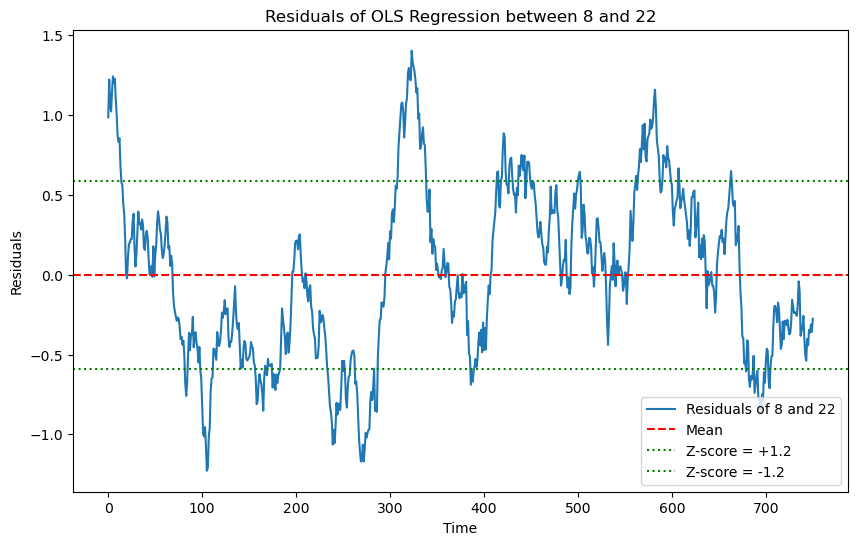

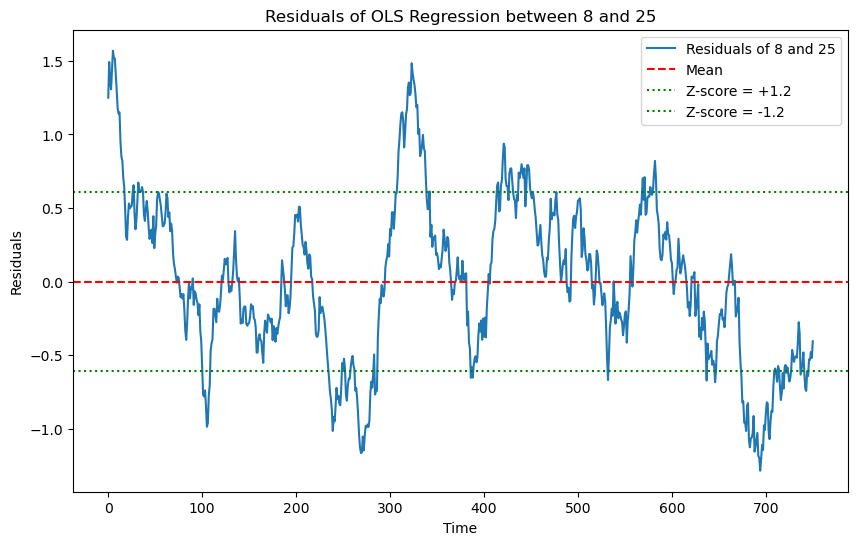

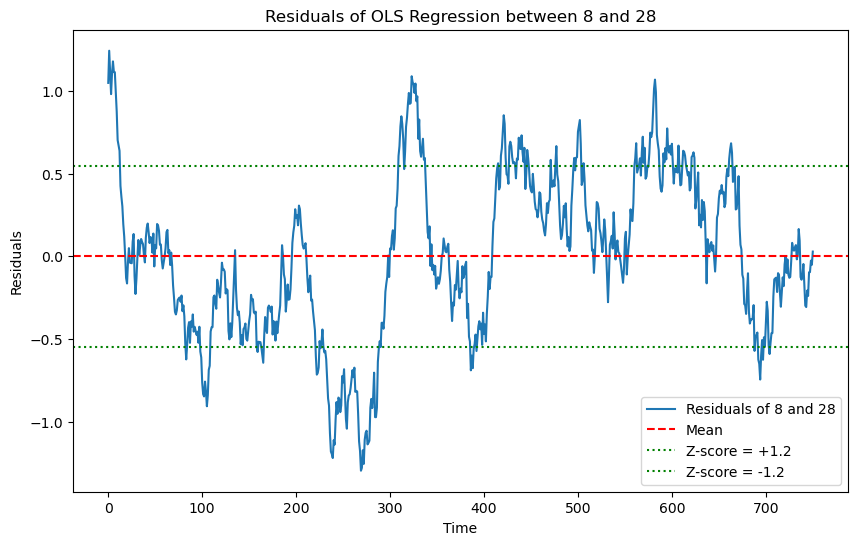

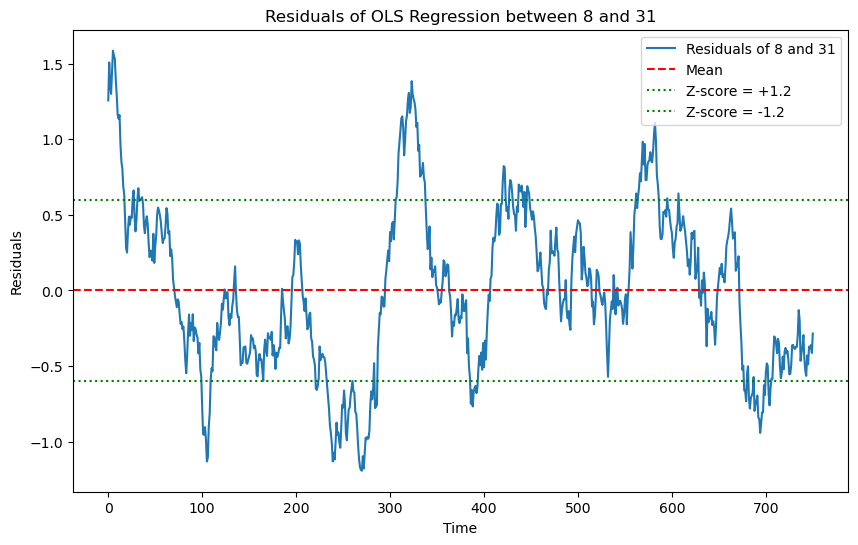

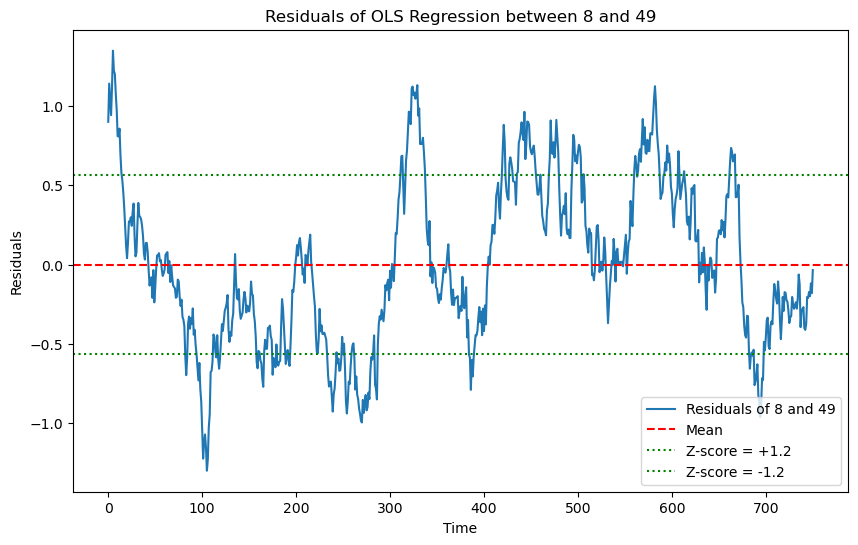

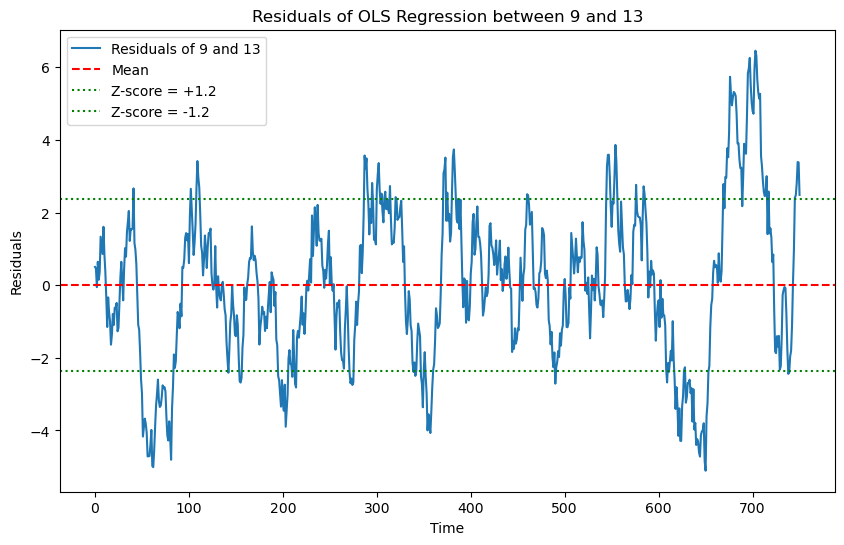

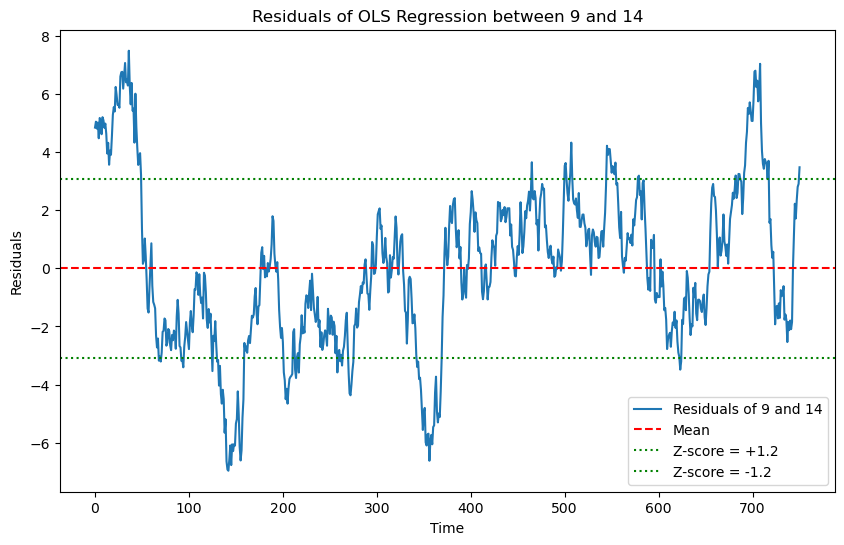

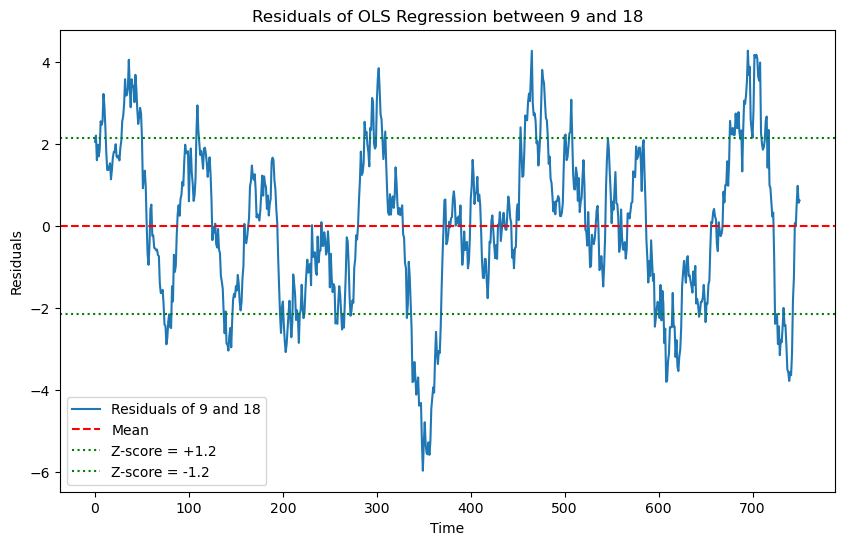

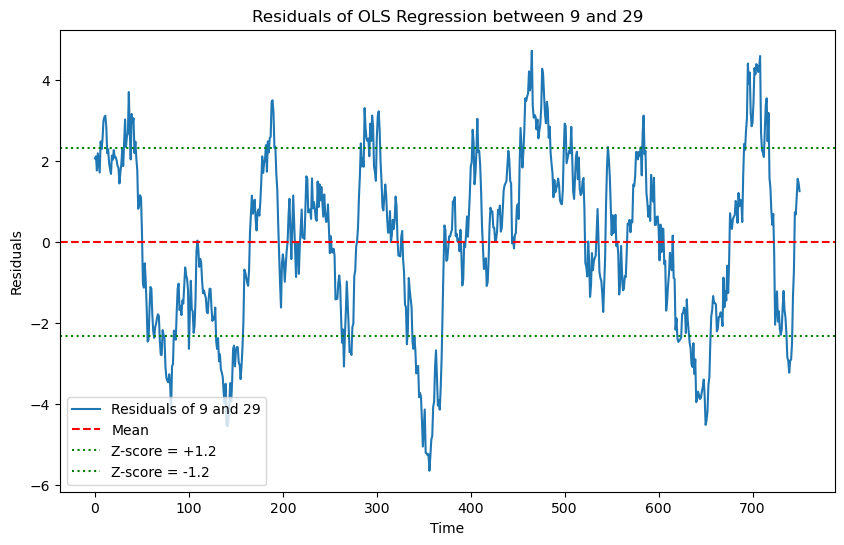

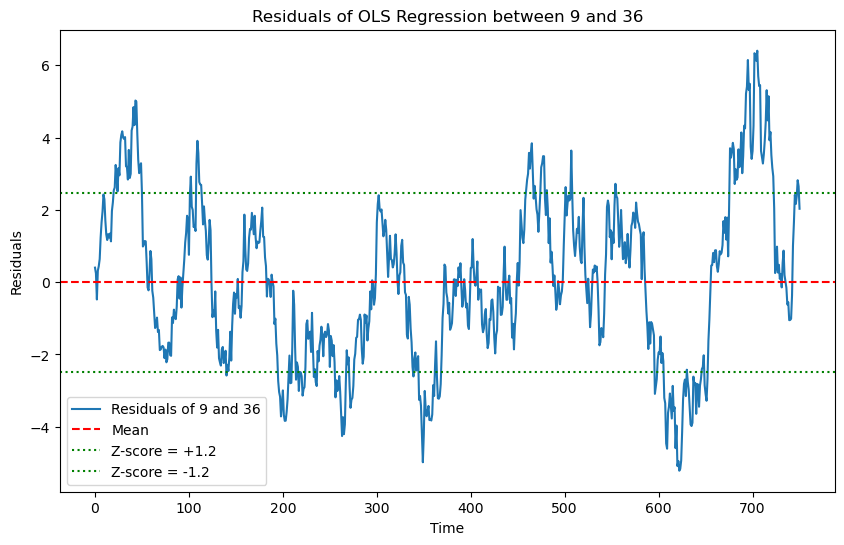

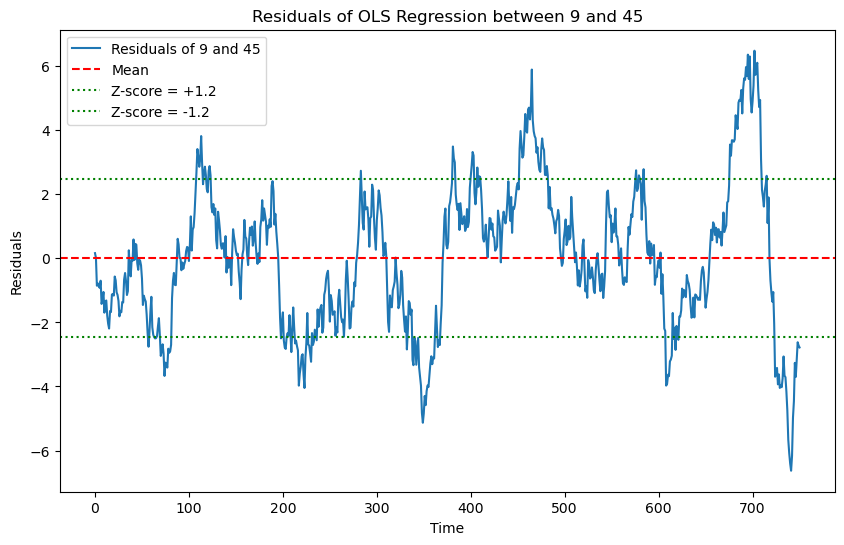

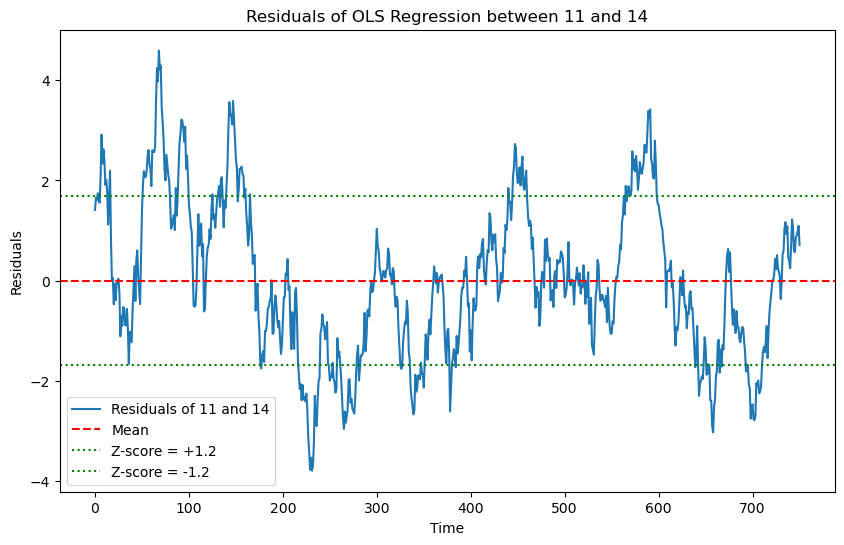

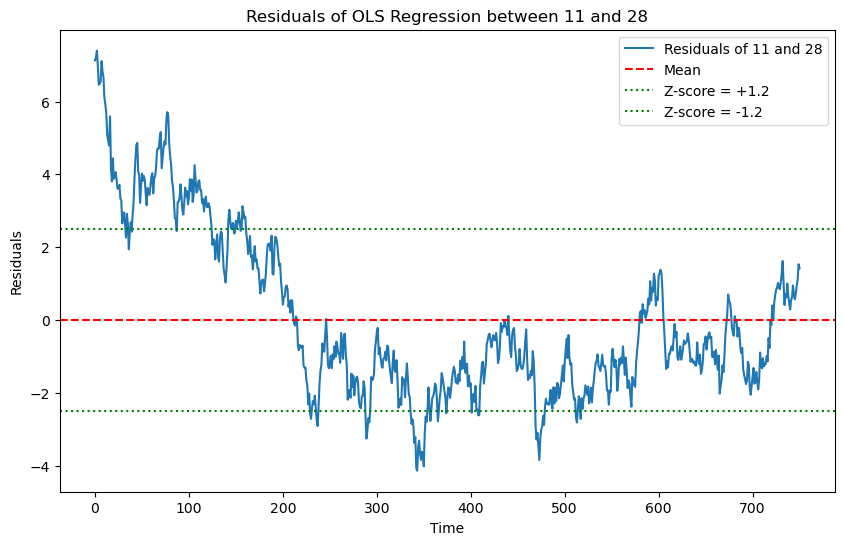

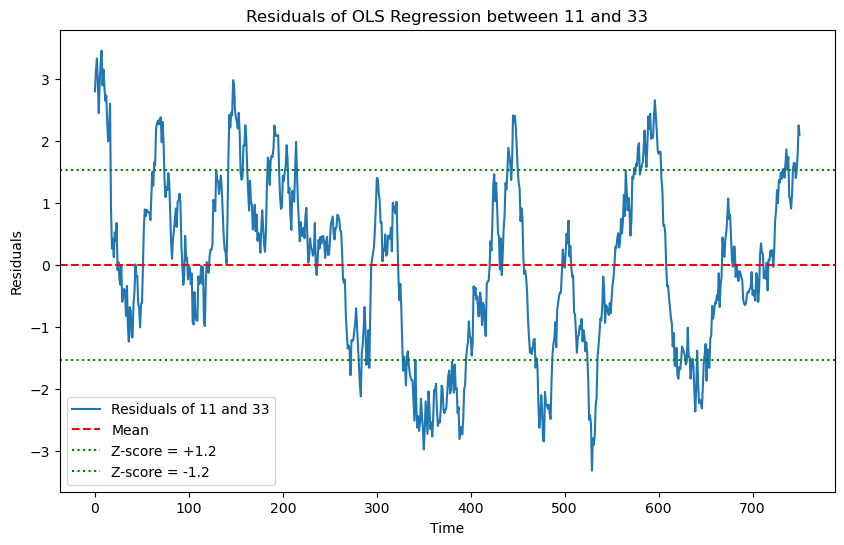

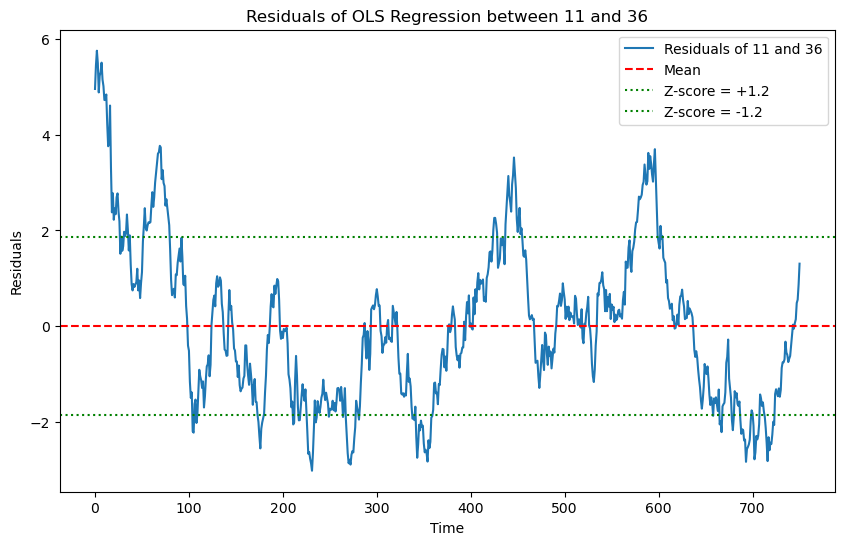

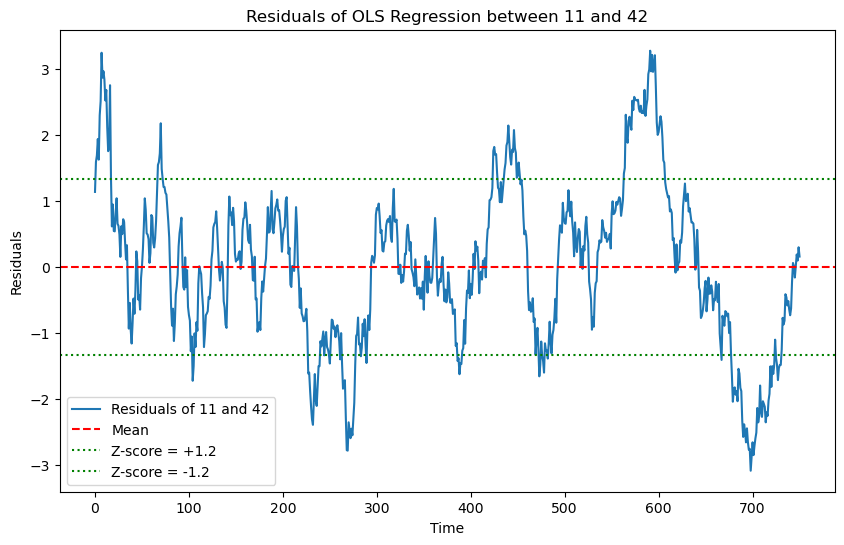

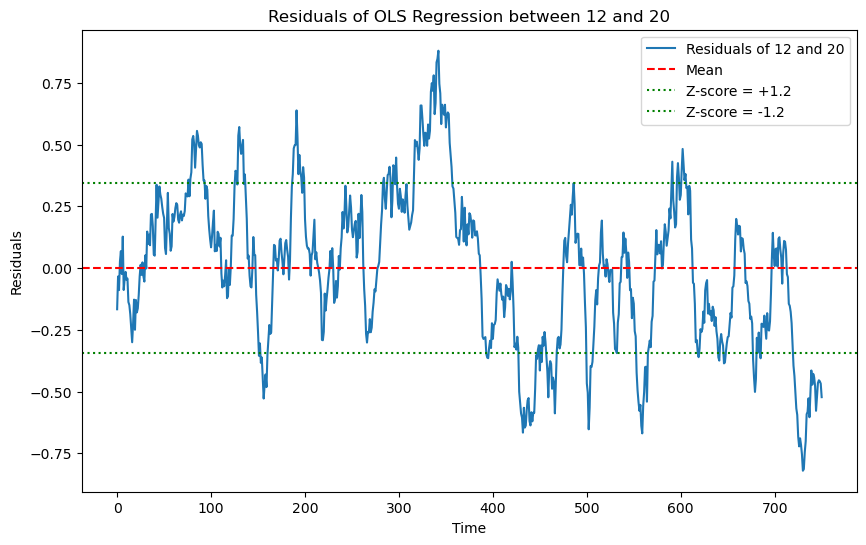

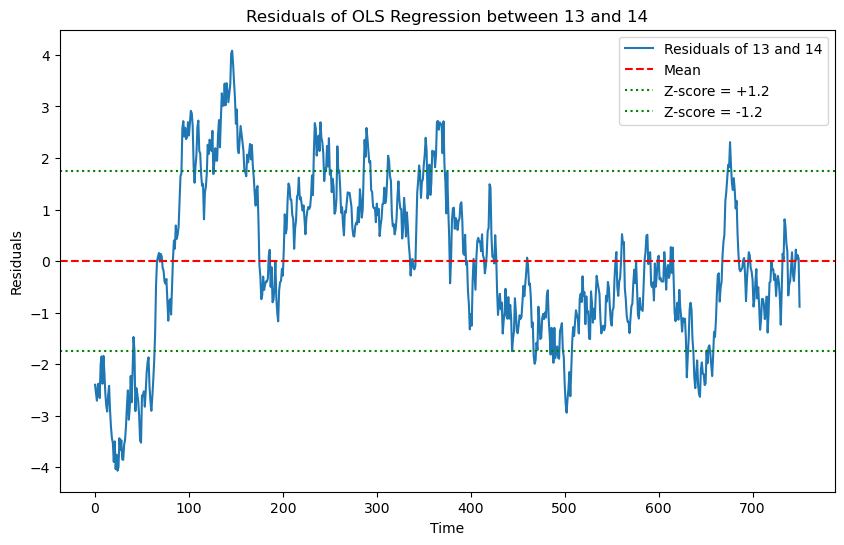

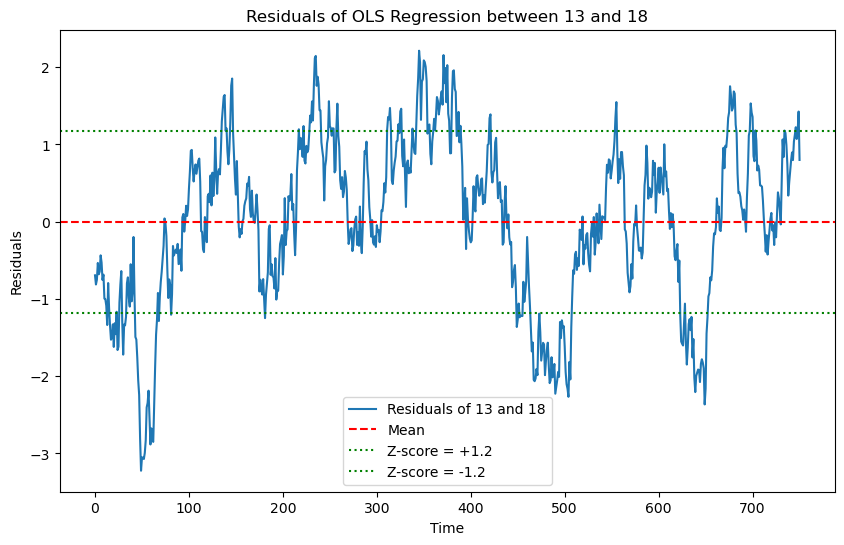

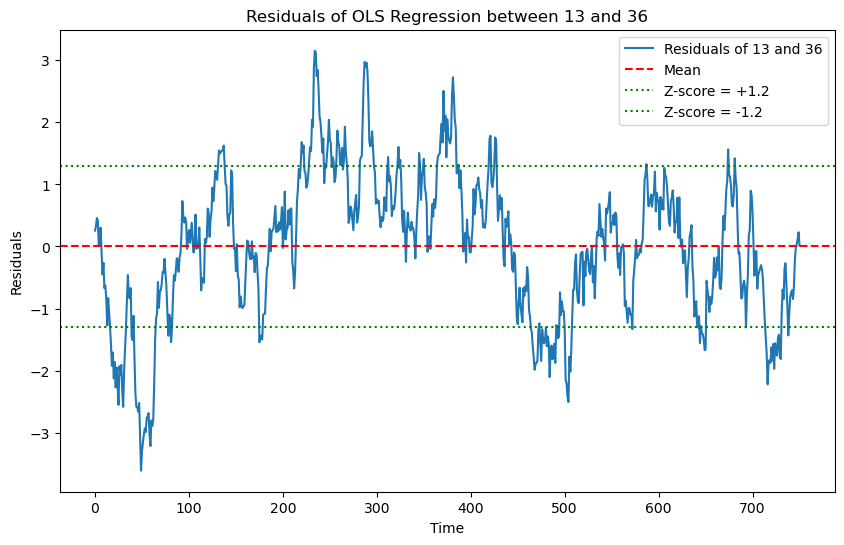

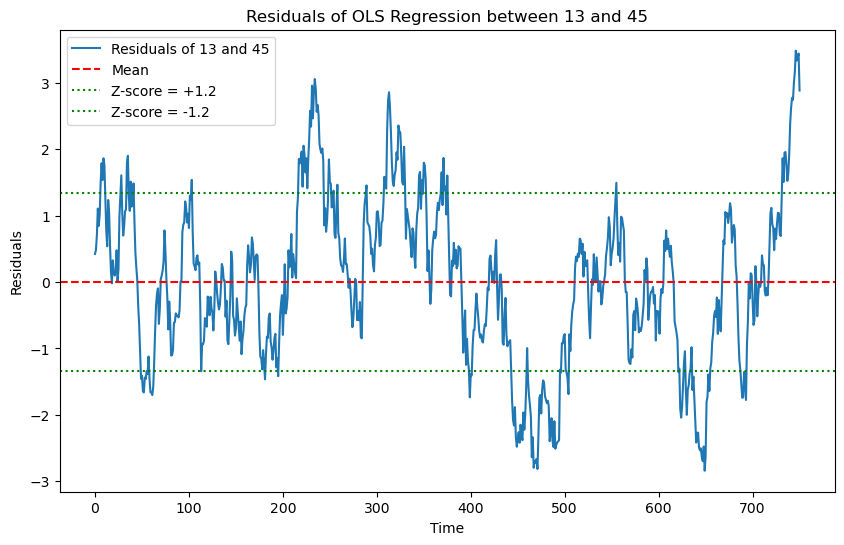

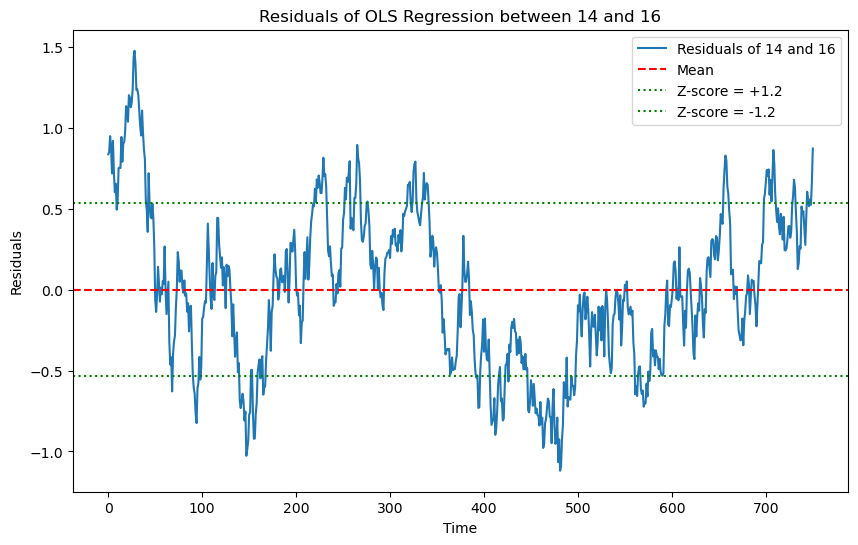

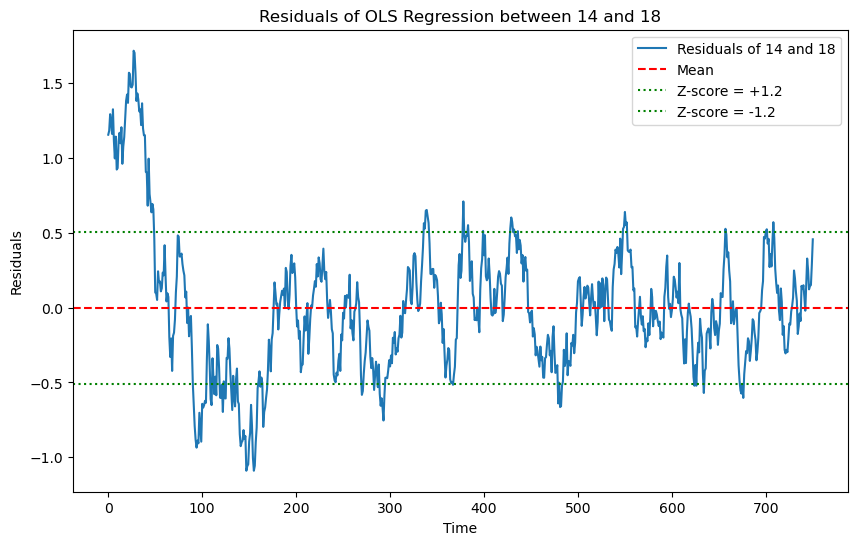

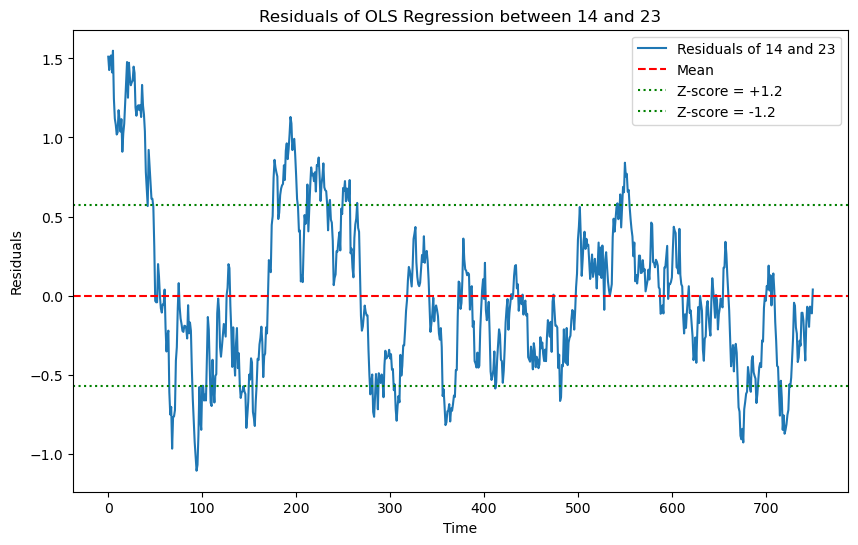

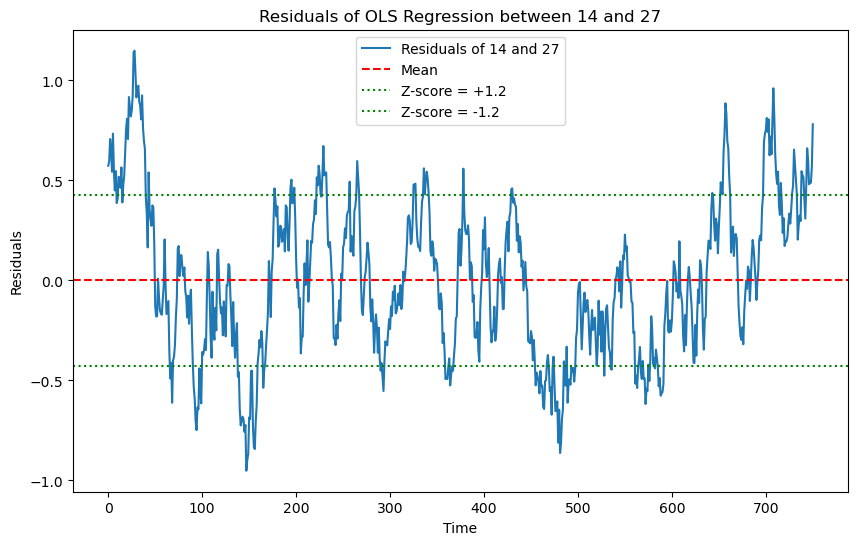

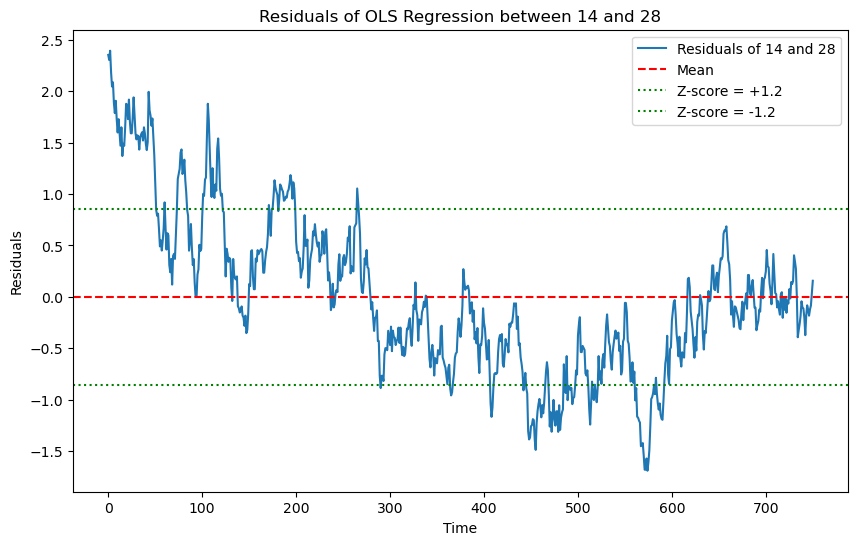

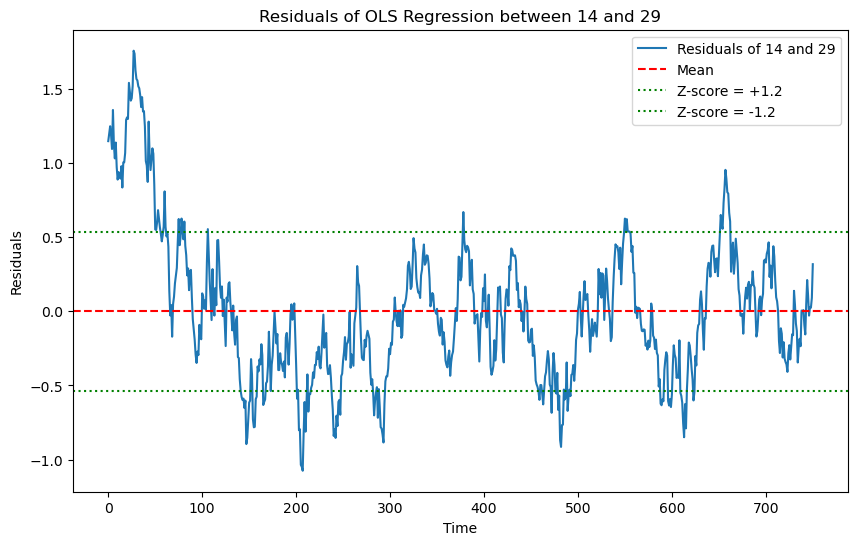

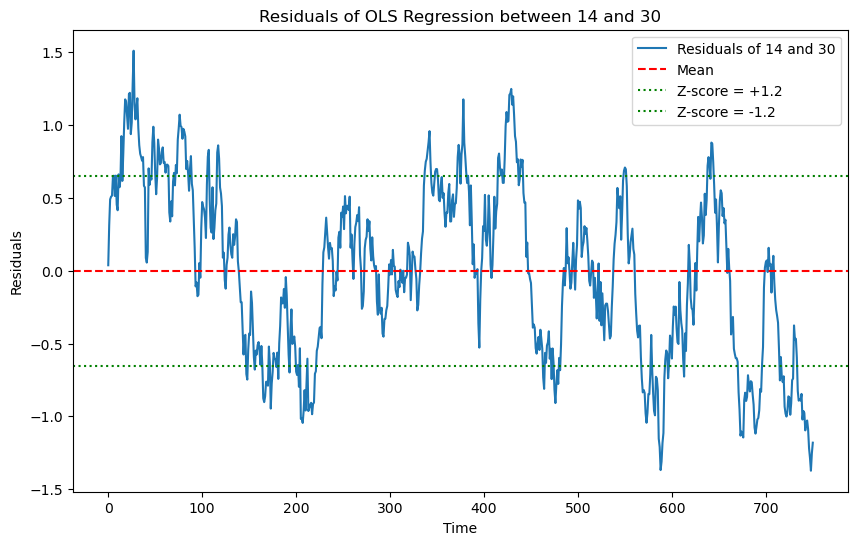

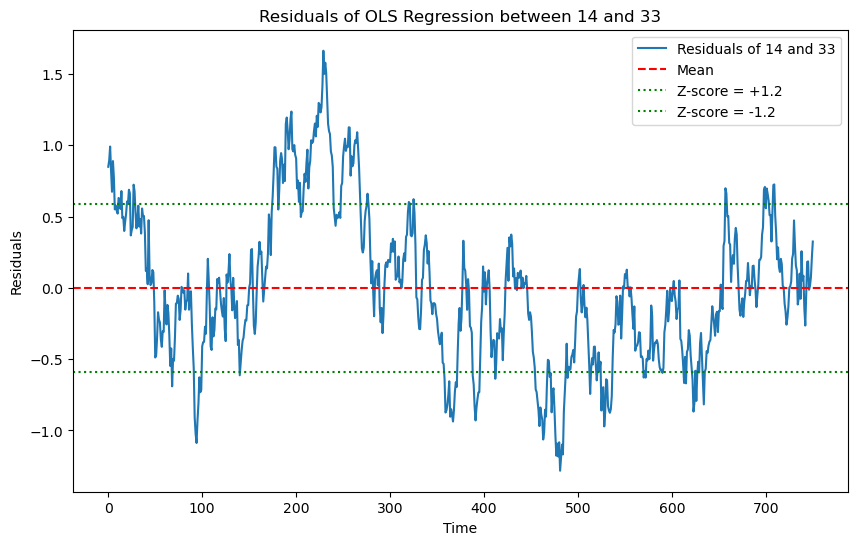

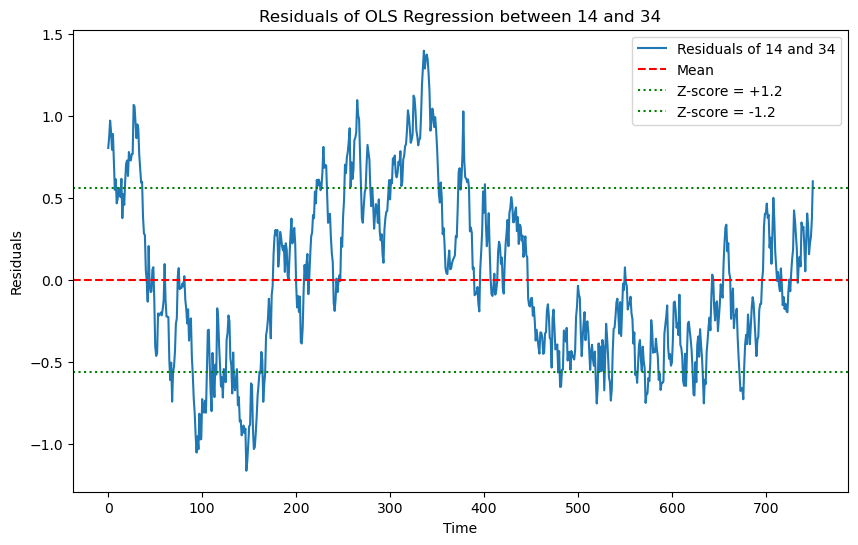

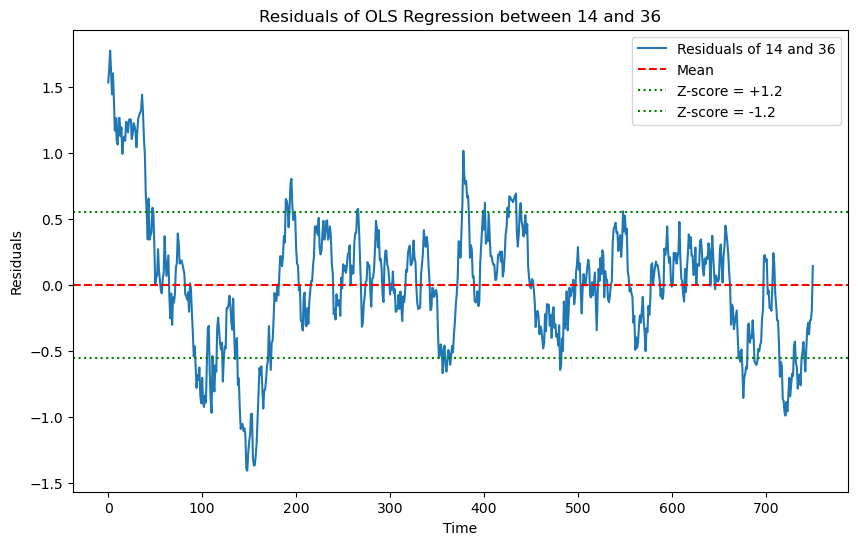

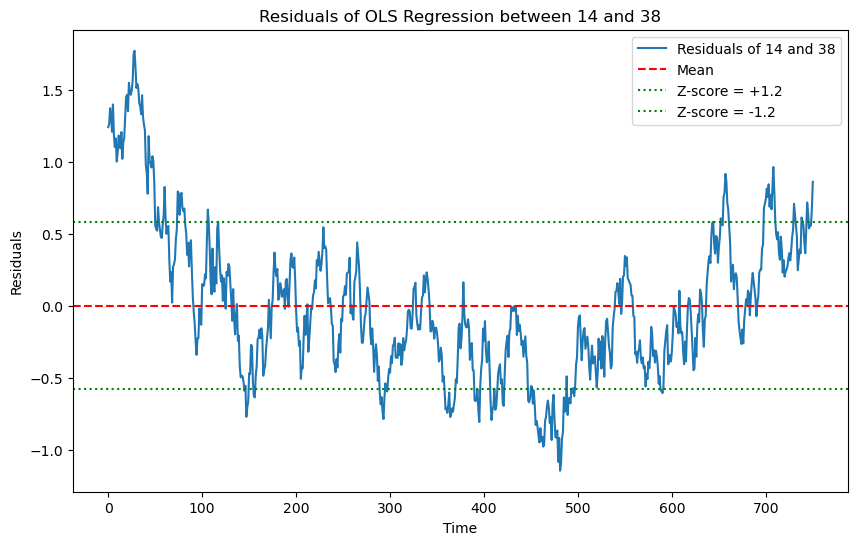

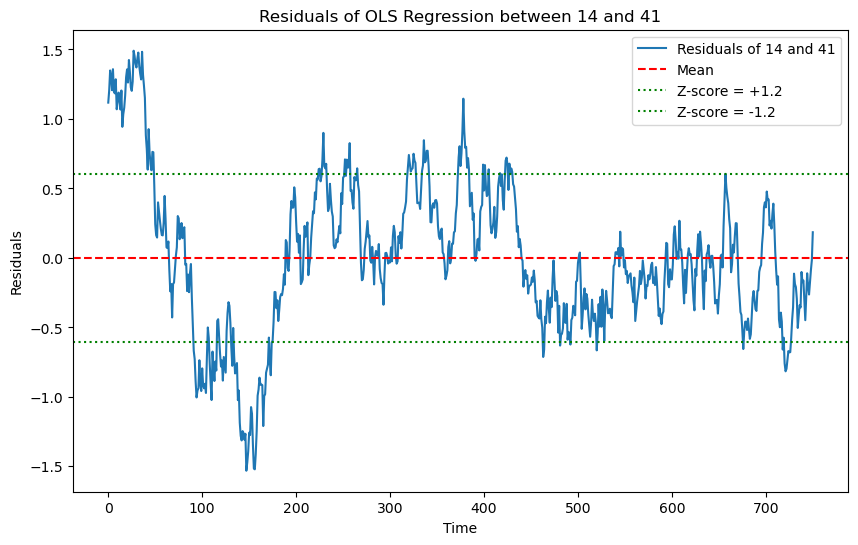

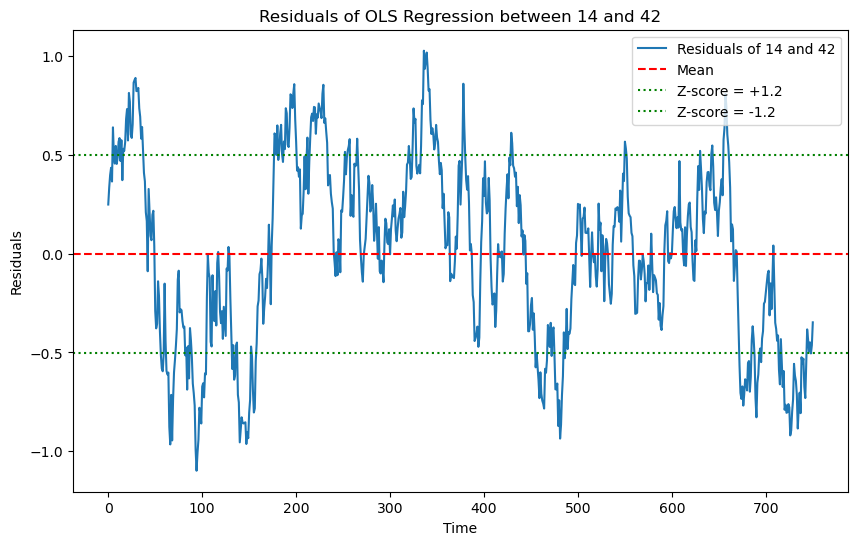

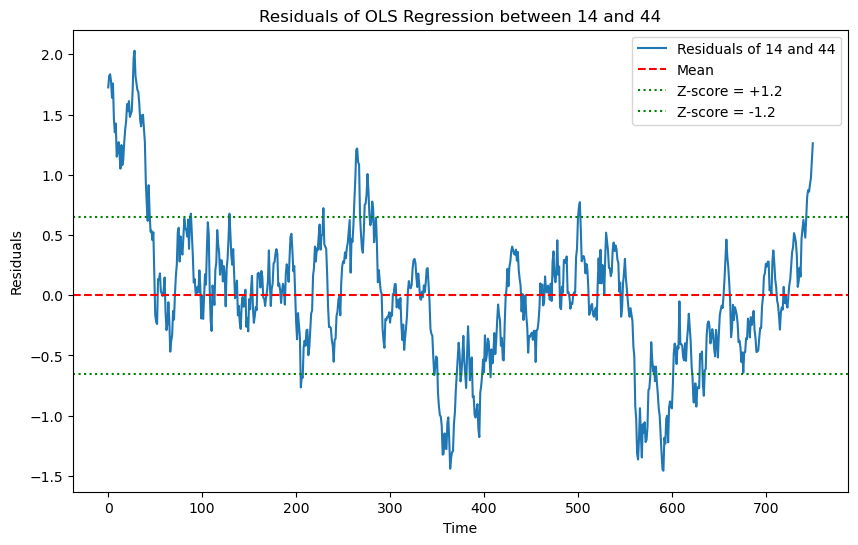

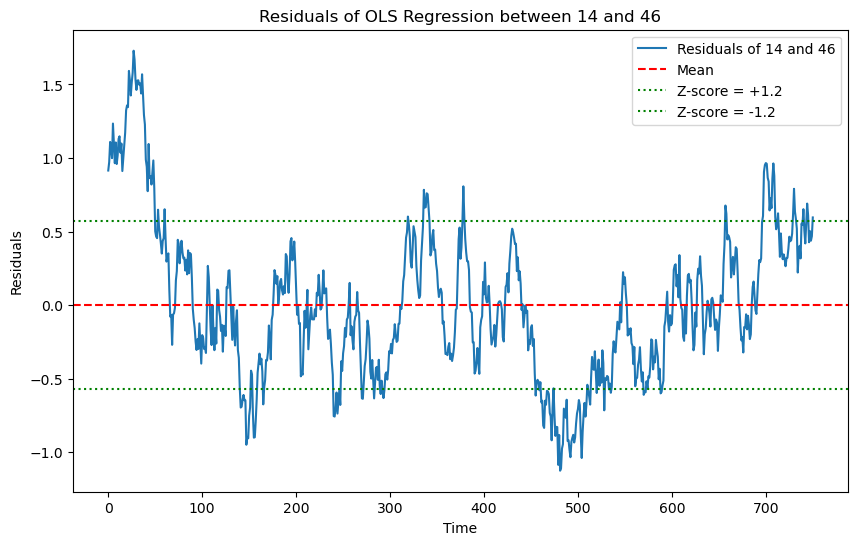

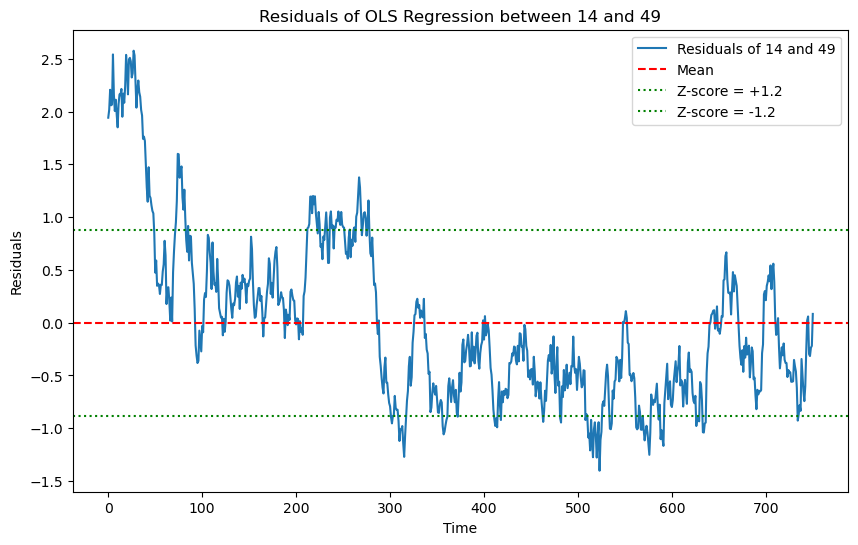

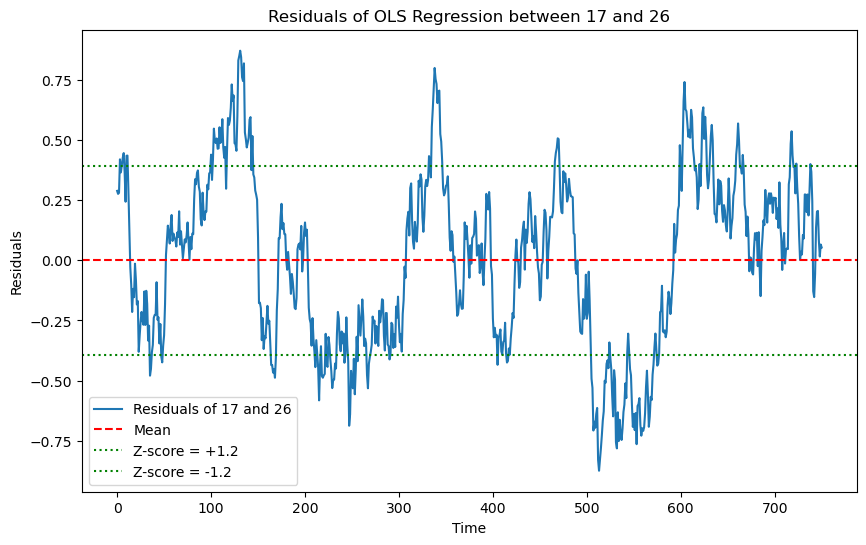

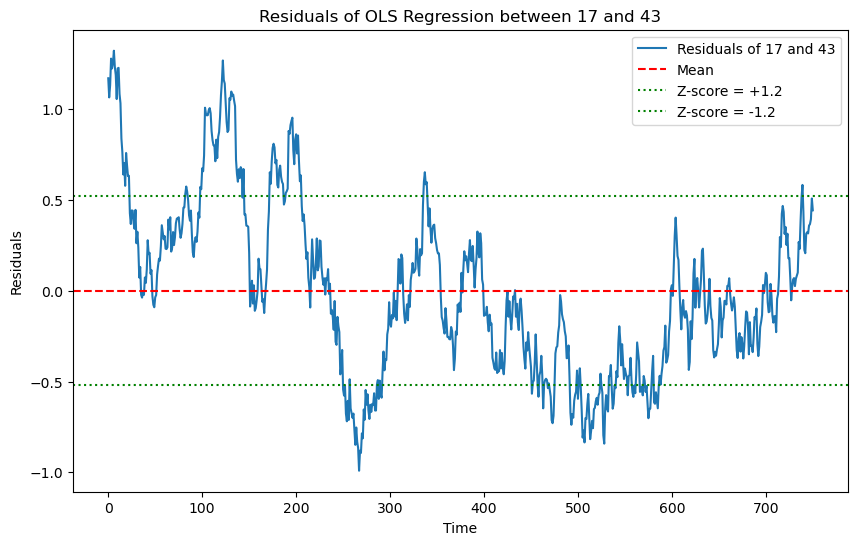

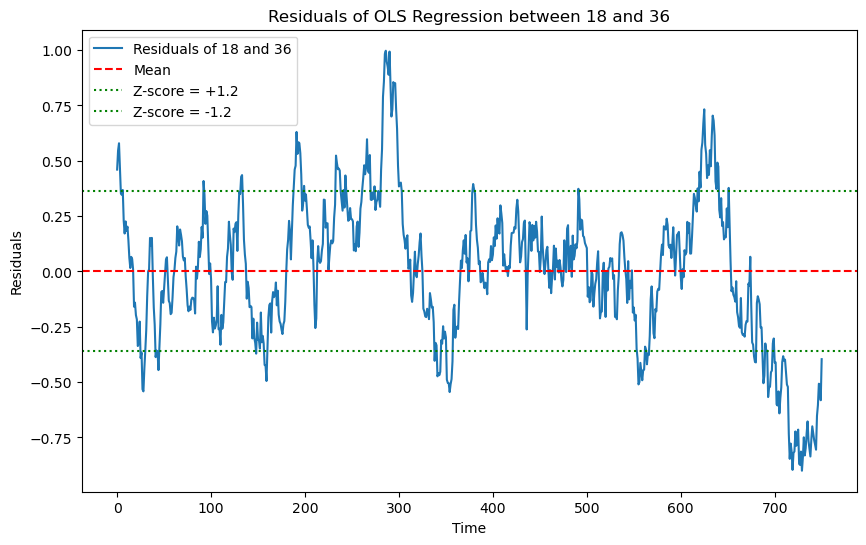

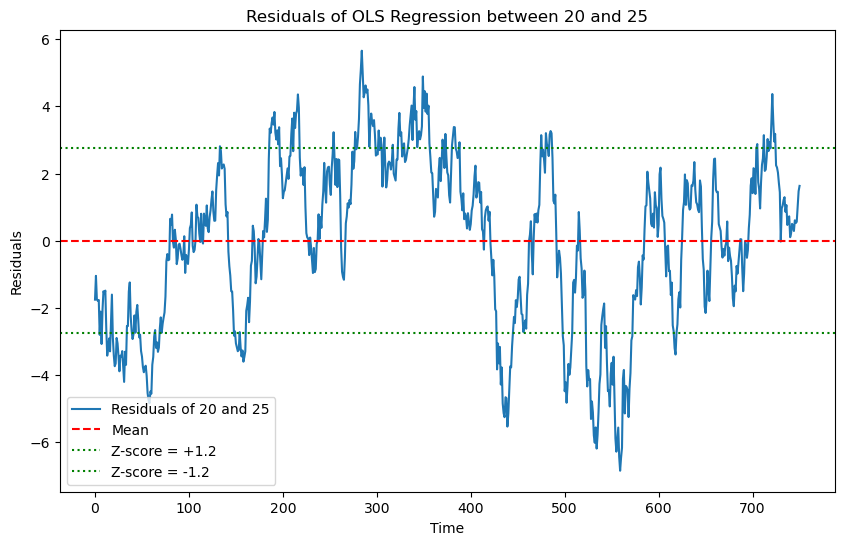

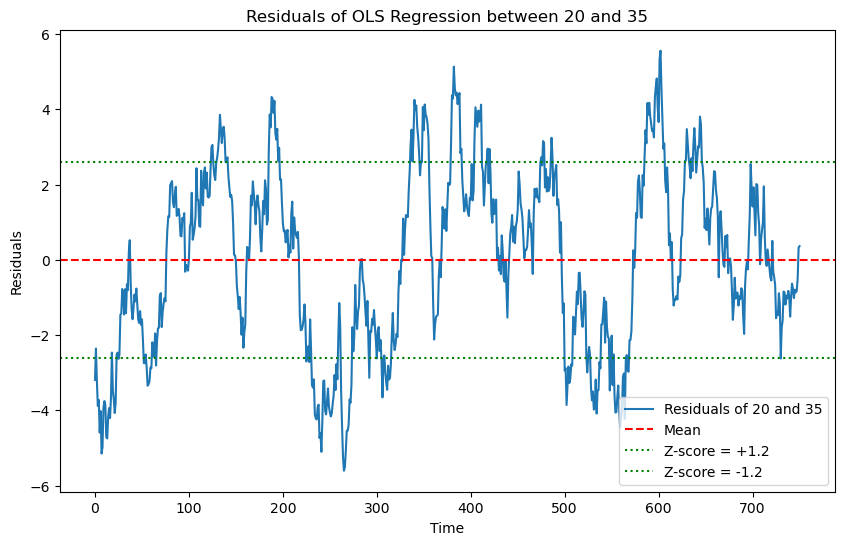

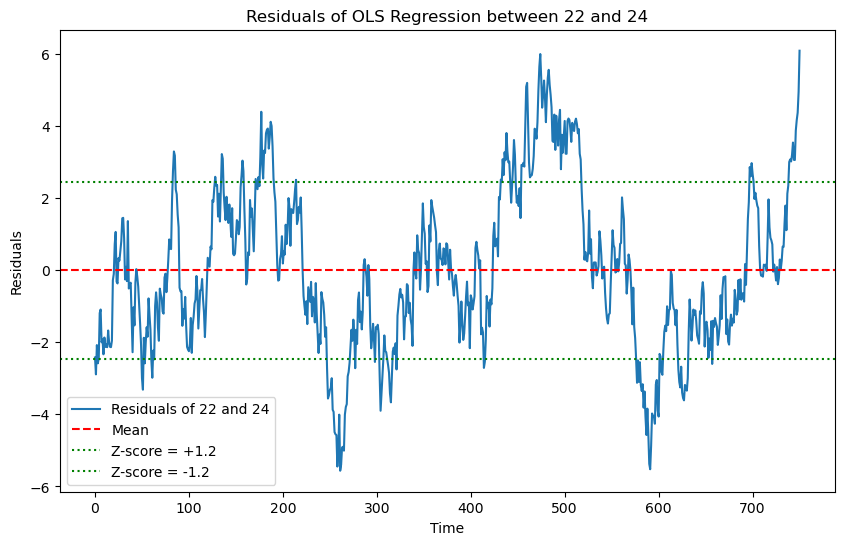

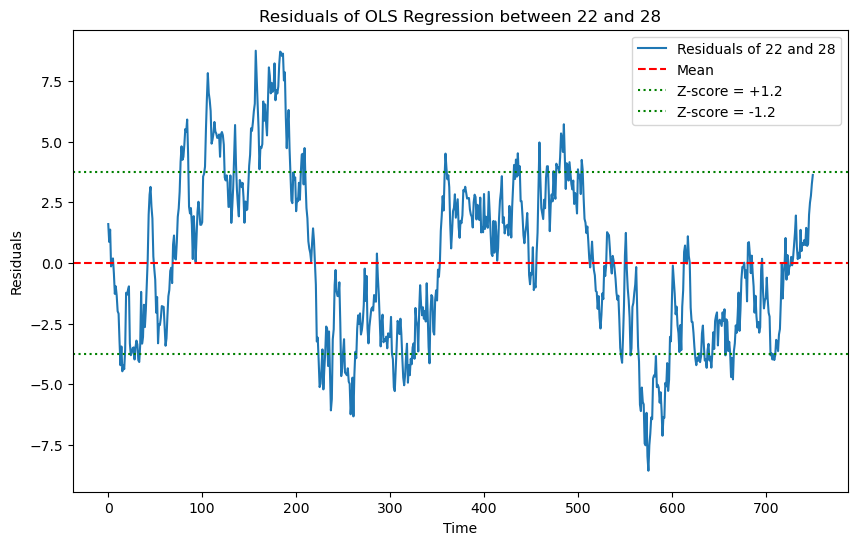

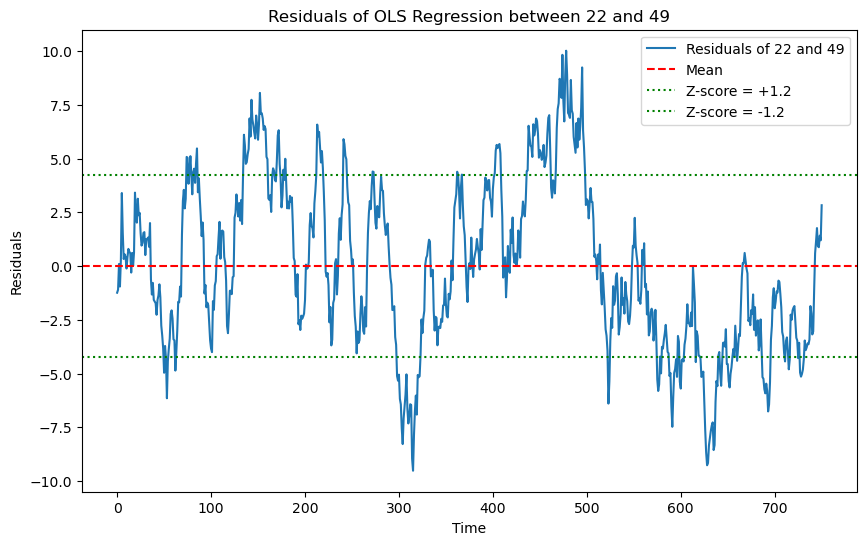

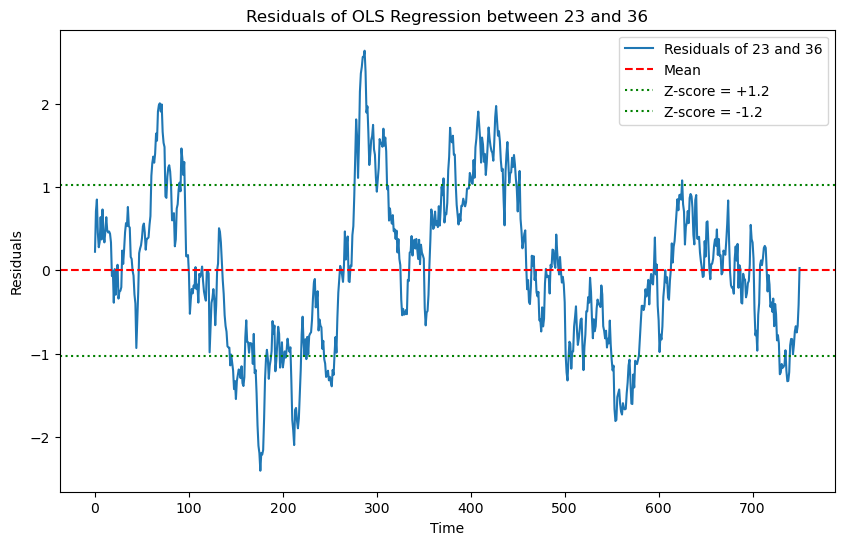

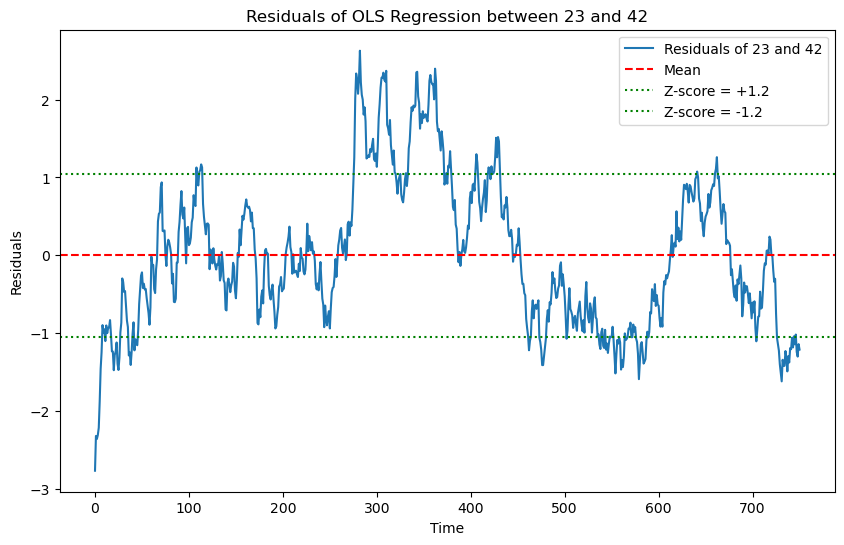

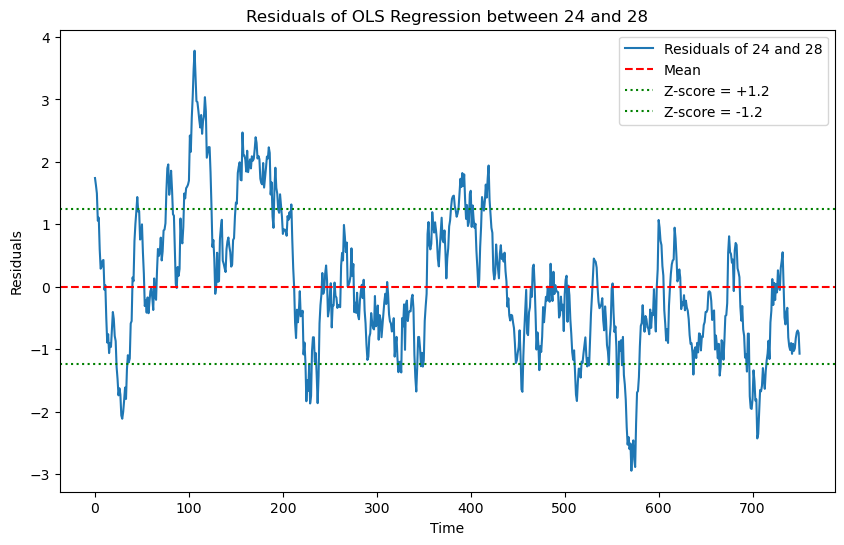

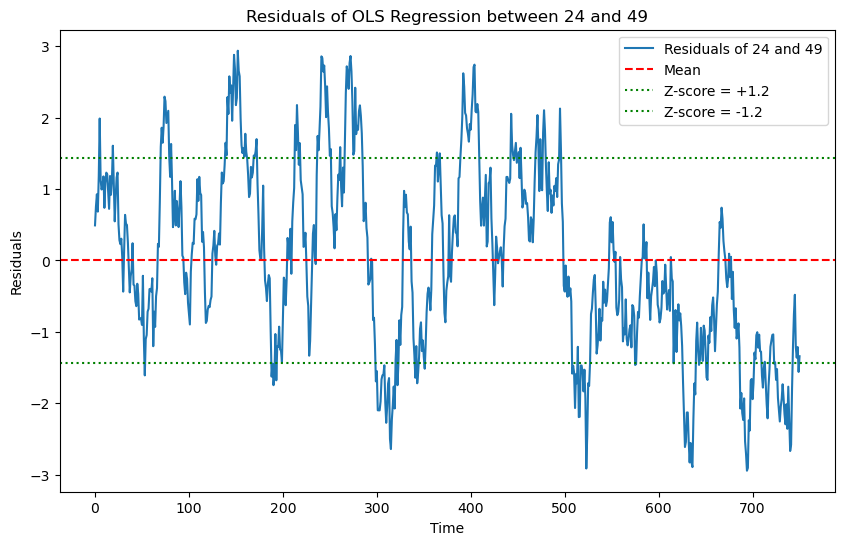

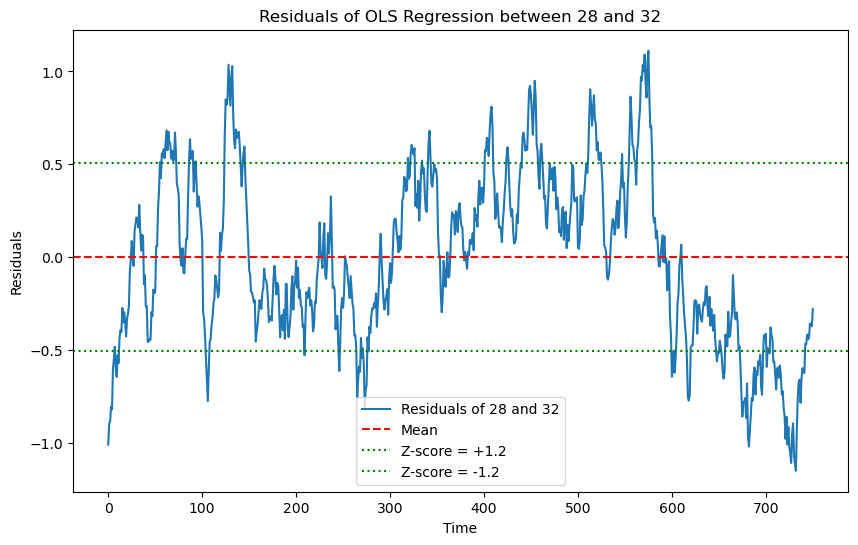

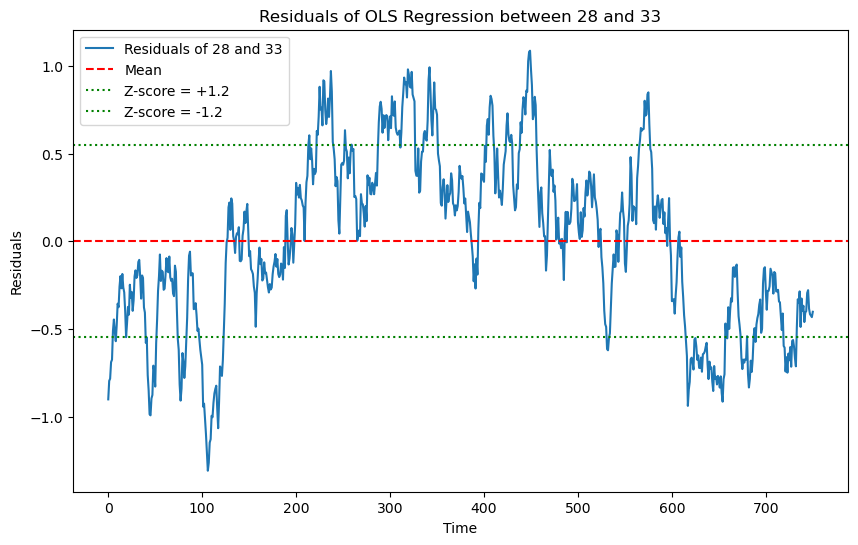

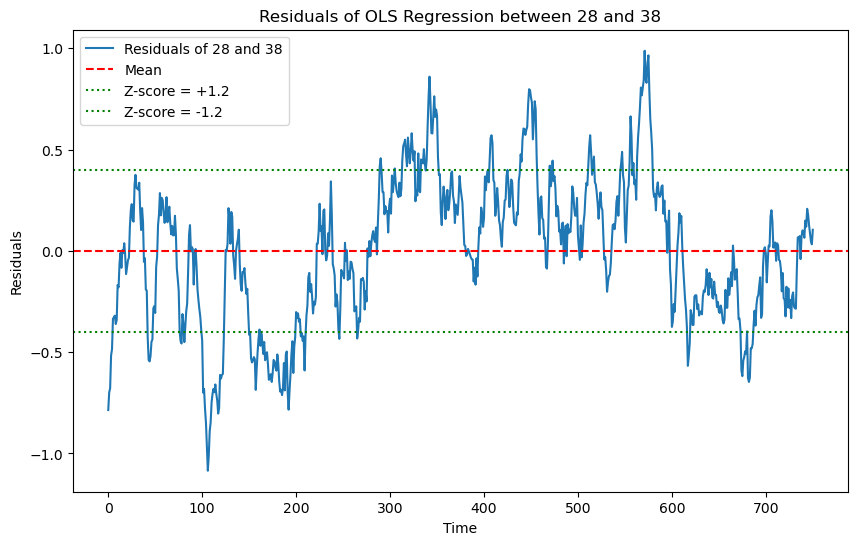

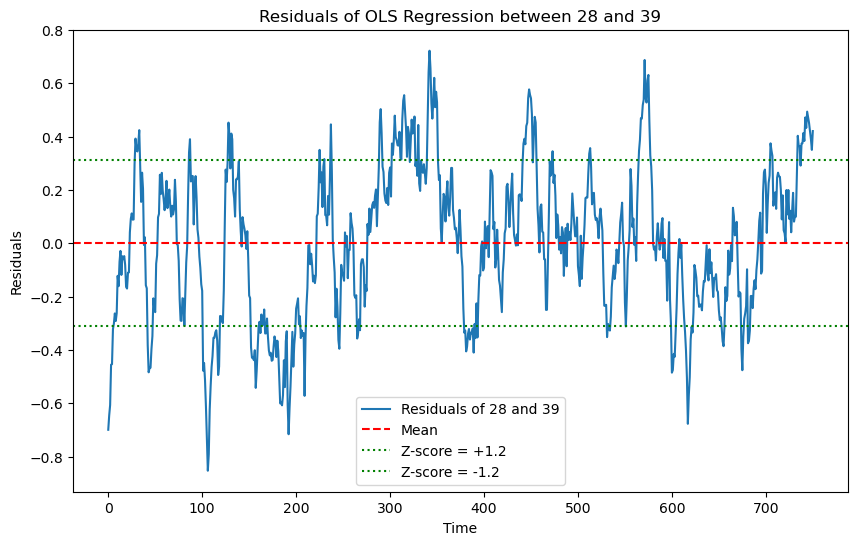

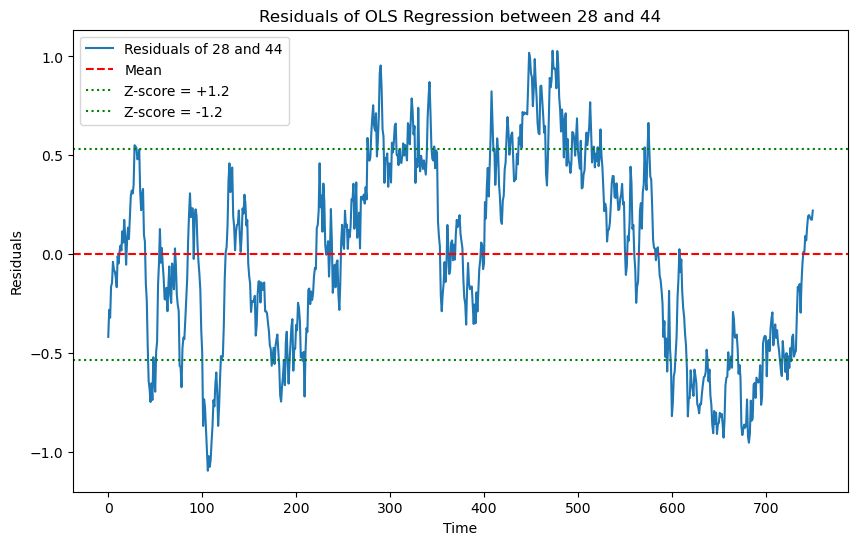

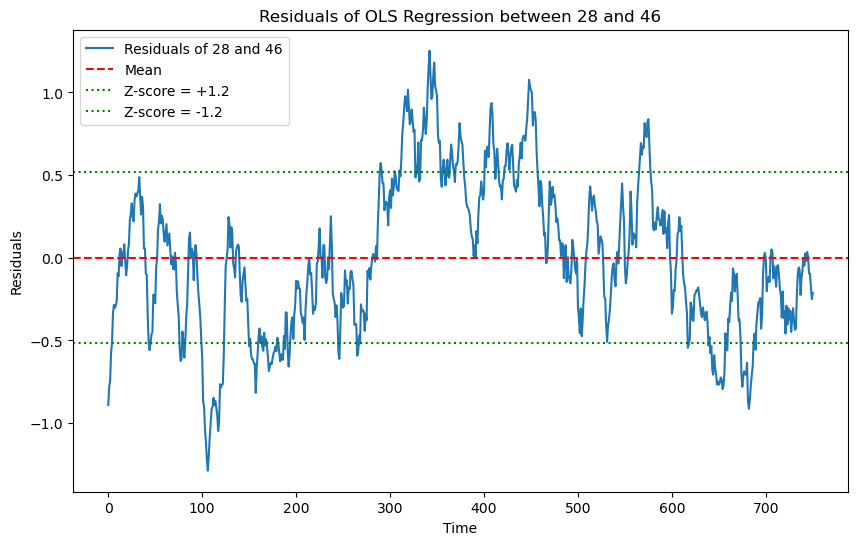

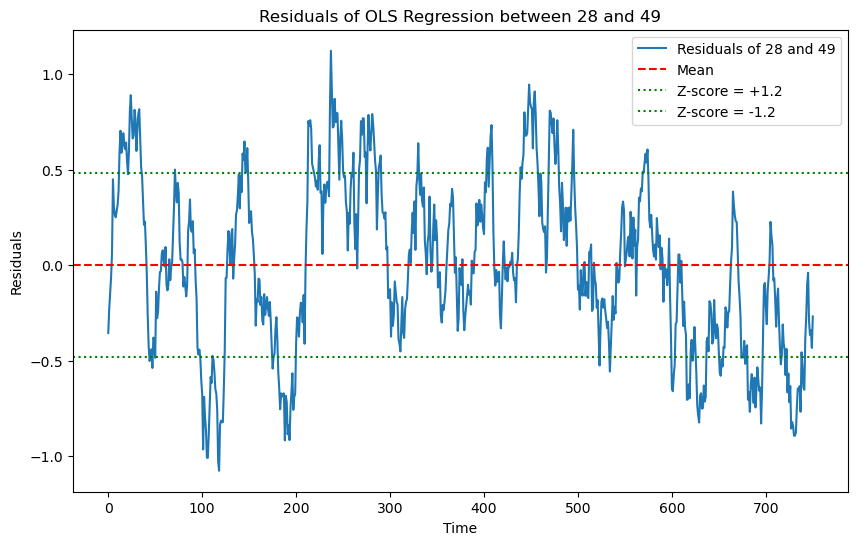

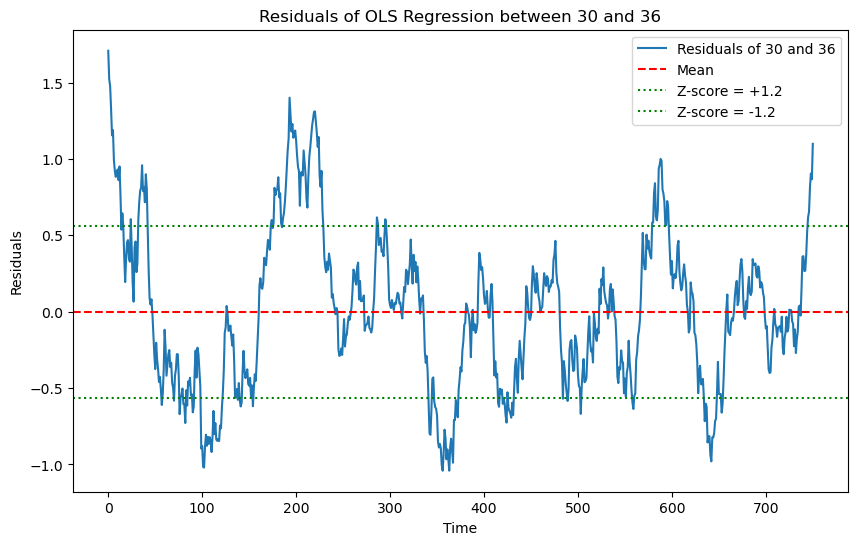

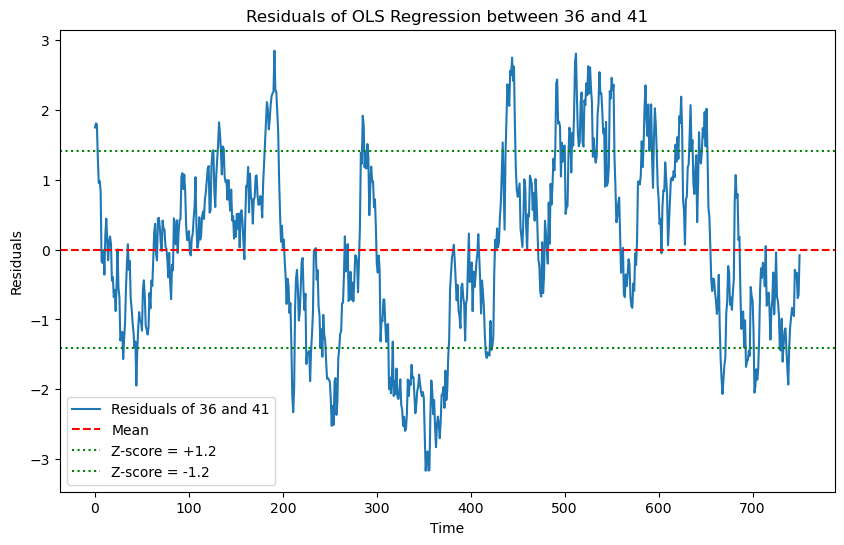

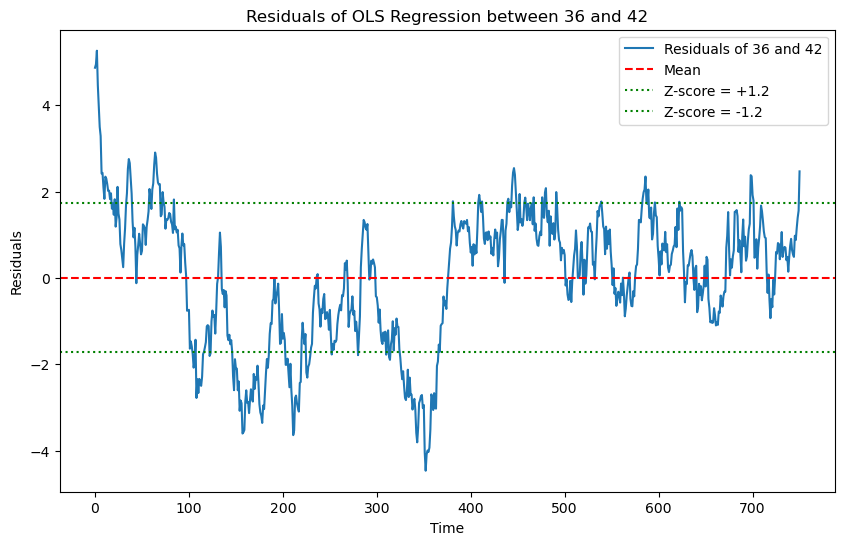

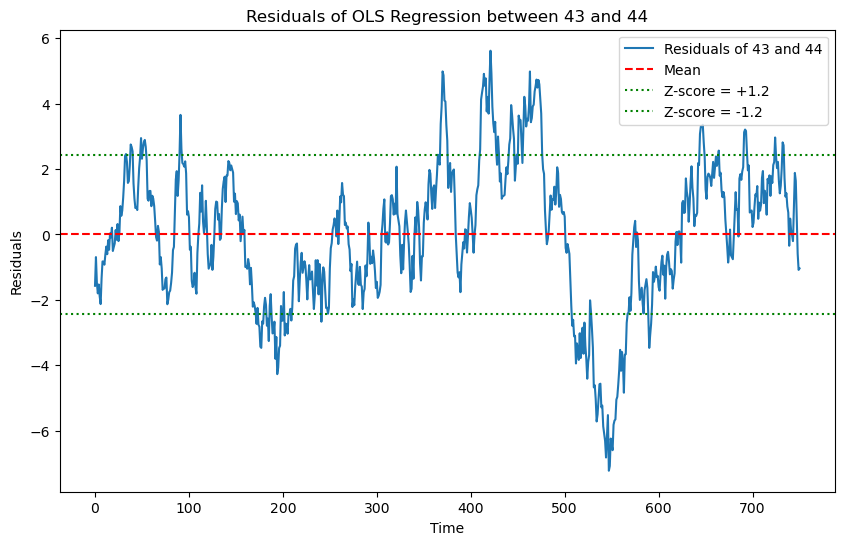

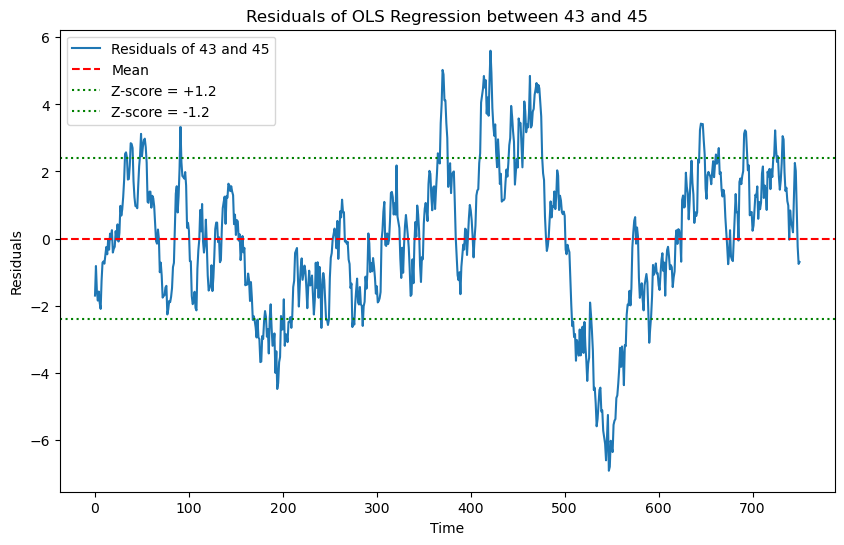

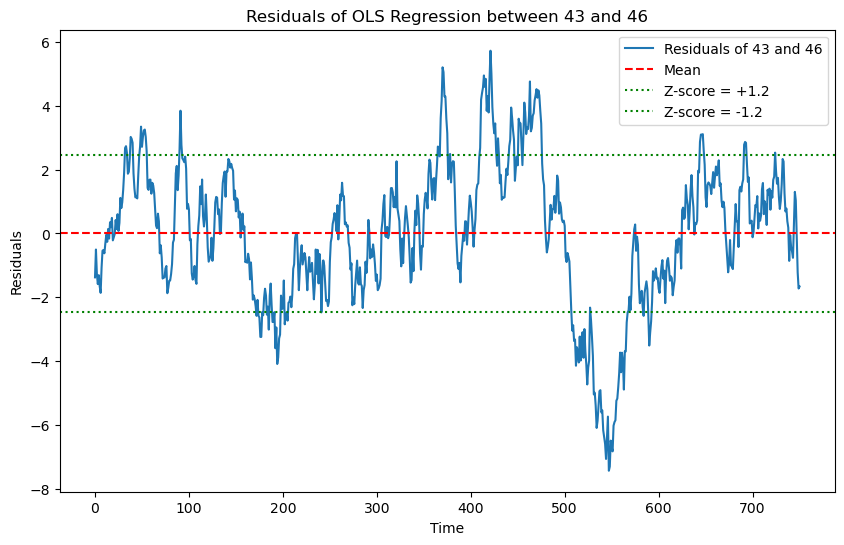

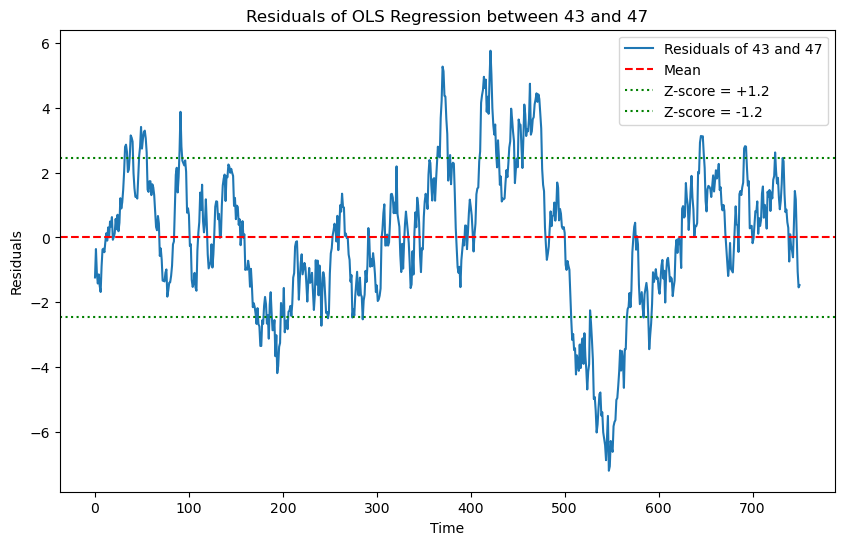

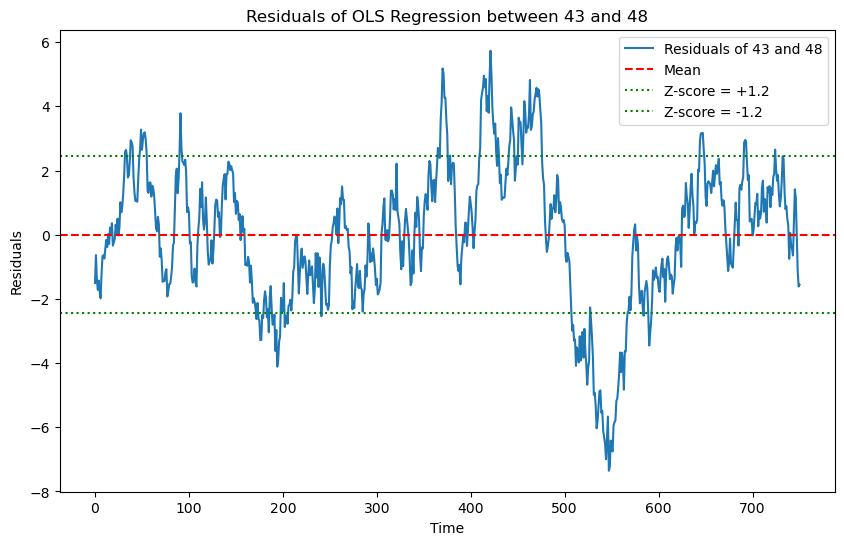

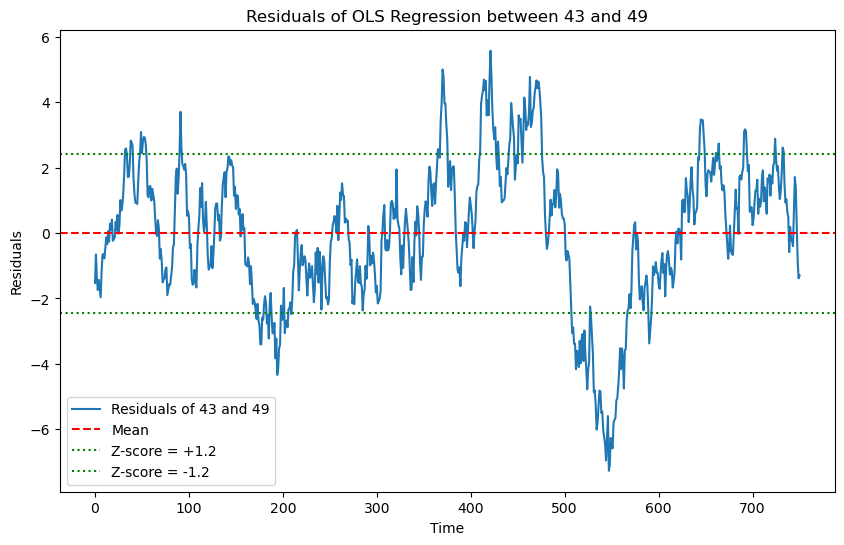

In [16]:
def select_pairs(prices):
    train_prc = pd.DataFrame(prices)
    n = train_prc.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    residual_matrix = np.zeros((n, n, len(train_prc)))
    keys = train_prc.keys()
    pairs = []
    for i in range(n):
        for j in range(i + 1, n):
            S1 = train_prc[keys[i]]
            S2 = train_prc[keys[j]]
            S2 = sm.add_constant(S2)
            model = sm.OLS(S1, S2).fit()
            residuals = model.resid
            residual_matrix[i, j] = residuals
            result = adfuller(residuals, maxlag=1)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.02:
                pairs.append((keys[i], keys[j]))
    return pairs, residual_matrix


# Call select_pairs and store both pairs and residual_matrix
pairs, residual_matrix = select_pairs(training_data)


# Now you can use these in your plotting functions
def plotresids(pairs, residual_matrix, pruned_log_prices):
    for pair in pairs:
        i, j = pruned_log_prices.columns.get_loc(
            pair[0]
        ), pruned_log_prices.columns.get_loc(pair[1])
        residuals = residual_matrix[i, j]
        plot_residuals(pair, residuals)

pruned_log_prices = training_data.copy()
# Call the plotting function
plotresids(pairs, residual_matrix, pruned_log_prices)

In [ ]:
def select_pairs(prices):
    train_prc = pd.DataFrame(prices)
    # takes the pruend prices and performs coint pairs to get both pairs and residual matrices
    n = train_prc.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = train_prc.keys()
    pairs = []
    for i in range(n):
        for j in range(i + 1, n):
            S1 = train_prc[keys[i]]
            S2 = train_prc[keys[j]]
            S2 = sm.add_constant(S2)
            model = sm.OLS(S1, S2).fit()
            residuals = model.resid
            result = adfuller(residuals, maxlag=1)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.02:
                pairs.append((keys[i], keys[j]))
    used_stocks = set()
    unique_pairs = []
    for pair in pairs:
        stock1, stock2 = pair
        if stock1 not in used_stocks and stock2 not in used_stocks:
            unique_pairs.append(pair)
            used_stocks.add(stock1)
            used_stocks.add(stock2)

    return unique_pairs


selected_pairs = None
currentPos = np.zeros(50)


def getMyPosition(prcSoFar):
    global selected_pairs, position_open
    T = 4000
    prcSoFar = pd.DataFrame(prcSoFar).T
    lnprc = np.log(prcSoFar)
    selected_pairs = [
        (7, 9),
        (8, 47),
        (23, 42),
    ]
    ######WORKS UP TO HERE
    for stockA, stockB in selected_pairs:
        if stockA >= prcSoFar.shape[0] or stockB >= prcSoFar.shape[0]:
            continue
        lnret_A = np.diff(lnprc[stockA])
        lnret_B = np.diff(lnprc[stockB])

        # Calculate the ratio b
        std_A = np.std(lnret_A)
        std_B = np.std(lnret_B)

        b = std_A / std_B
        s = pd.Series(lnprc[stockA] - b * lnprc[stockB])
        m = s.rolling(window=21).mean()
        sig_ms = np.std(m - s)

        x = T / (1 + b)
        bx = b * x

        if s.iloc[-1] > m.iloc[-1] + sig_ms:
            currentPos[stockA] = 0  # Close position on stockA
            currentPos[stockB] = 0  # Close position on stockB
        elif s.iloc[-1] > m.iloc[-1] + sig_ms and s.iloc[-1] < m.iloc[-1] + 2 * sig_ms:
            if currentPos[stockA] > 0:  # If currently long, close it first
                currentPos[stockA] = 0
            if currentPos[stockB] < 0:  # If currently short, close it first
                currentPos[stockB] = 0
            currentPos[stockA] -= x / (
                prcSoFar.iloc[-1, stockA]
            )  # Open short position on stockA
            currentPos[stockB] += x / (
                prcSoFar.iloc[-1, stockB]
            )  # Open long position on stockB
        elif s.iloc[-1] < m.iloc[-1] - sig_ms and s.iloc[-1] > m.iloc[-1] - 2 * sig_ms:
            if currentPos[stockA] < 0:  # If currently short, close it first
                currentPos[stockA] = 0
            if currentPos[stockB] > 0:  # If currently long, close it first
                currentPos[stockB] = 0
            currentPos[stockA] += x / (
                prcSoFar.iloc[-1, stockA]
            )  # Open long position on stockA
            currentPos[stockB] -= x / (
                prcSoFar.iloc[-1, stockB]
            )  # Open short position on stockB
        elif (
            s.iloc[-1] < m.iloc[-1] - 2 * sig_ms or s.iloc[-1] > m.iloc[-1] + 2 * sig_ms
        ):
            currentPos[stockA] = 0  # Close position on stockA
            currentPos[stockB] = 0  # Close position on stockB

    return currentPos